### IMPORTS

In [1]:
%%time
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
from scipy import stats

import abt
# This module contains 3 self-made functions:
# read_abt(x)
# p_factor(*factor, goal, df, variations=[1,2], min=50)
# tta(*factor, goal, df, variations=[1,2], min=50)


# Import VIZ Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import altair as alt
import pygal

# Jupyter Settings
pd.options.display.max_columns = None
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.max_rows", 200)

%config InlineBackend.figure_format = 'retina' # display plots in retina

# Output Multiple Values for Cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Output logs and warnings
import logging
logging.basicConfig(level=logging.WARNING)

import warnings
warnings.filterwarnings('ignore')

# Global Variables
AP, DC, FC, MB, SC = 539414, 527076, 539416, 539420, 529239

import boto3
s3 = boto3.resource('s3')
bucket=s3.Bucket('vwo-ab-tests-bucket')
filelist = [] 
for file in bucket.objects.all():
    filelist.append(file.key) 
s_filelist = pd.Series(filelist)

print("Setup Complete")

Setup Complete
CPU times: user 3.2 s, sys: 942 ms, total: 4.14 s
Wall time: 6.2 s


## CLEAR DATA

In [2]:
exp = 66

### LOAD EXP FROM AMAZON S3

In [3]:
current = FC

In [4]:
%%time
# LOAD META REPORT
s3 = boto3.client('s3')
meta_list = list(s_filelist[s_filelist.str.contains('meta')\
                            & s_filelist.str.contains('{}/{}/'.format(current, exp), regex=True)])
obj = s3.get_object(Bucket='vwo-ab-tests-bucket', Key=meta_list[0])
meta = pd.read_csv(obj['Body'], compression='gzip')

print('SHAPE of META file =', meta.shape)
print('WORKING FILE = ', meta_list[0])

SHAPE of META file = (7, 6)
WORKING FILE =  539416/66/meta.csv.gz
CPU times: user 27.2 ms, sys: 5.03 ms, total: 32.2 ms
Wall time: 349 ms


In [5]:
%%time
# LOAD AND CLEAN LAST DETAILED REPORT
s3 = boto3.client('s3')
detailed = list(s_filelist[s_filelist.str.contains('^(?!.*meta).*$', regex=True)\
                           & s_filelist.str.contains('{}/{}/'.format(current, exp), regex=True)]\
                           .sort_values(ascending=False))
obj = s3.get_object(Bucket='vwo-ab-tests-bucket', Key=detailed[0])
original = abt.read_abt(obj['Body'], meta=meta)

print('ORIGINAL SHAPE as is in S3 =',original.shape)
print('WORKING FILE = ', detailed[0])

ORIGINAL SHAPE as is in S3 = (2246, 45)
WORKING FILE =  539416/66/20211129.csv.gz
CPU times: user 187 ms, sys: 16.7 ms, total: 204 ms
Wall time: 639 ms


In [6]:
%%time
# LOAD RAW REPORT
s3 = boto3.client('s3')
detailed = list(s_filelist[s_filelist.str.contains('^(?!.*meta).*$', regex=True)\
                           & s_filelist.str.contains('{}/{}/'.format(current, exp), regex=True)]\
                           .sort_values(ascending=False))
obj = s3.get_object(Bucket='vwo-ab-tests-bucket', Key=detailed[0])
raw = pd.read_csv(obj['Body'], compression='gzip')

print('RAW SHAPE as is in S3 =', raw.shape)

RAW SHAPE as is in S3 = (2246, 33)
CPU times: user 48.6 ms, sys: 7.1 ms, total: 55.7 ms
Wall time: 398 ms


In [12]:
(metrics := list(meta[:-3]['name']))

['engagement', 'ftd', 'track_user_break', 'track_selfexclusion']

In [13]:
meta

,category,id,name,type,created_timestamp,info
0,goal,1,engagement,engagement,2021-11-05 10:12:57,NaN
1,goal,203,ftd,custom-conversion,2021-11-04 13:17:44,NaN
2,goal,208,track_user_break,custom-conversion,2021-11-04 13:17:44,NaN
3,goal,209,track_selfexclusion,custom-conversion,2021-11-04 13:17:44,NaN
4,combination,1,Control,NaN,NaN,NaN
5,combination,2,Variation 1,NaN,NaN,NaN
6,campaign,66,[ABT-23] Limits,NaN,NaN,NaN


#### Write & Read WORKING FILE

In [14]:
# WRITE DETAILED FILE TO DF
df = original.copy()
print('ORIGINAL SHAPE =', original.shape)
print('DF SHAPE =', df.shape)

ORIGINAL SHAPE = (2246, 45)
DF SHAPE = (2246, 45)


In [15]:
original.head()

,screen_resolution,query_parameters,ip,browser,browser_version,device_type,device,os,os_version,user_agent,traffic_source,combination_id,combination_name,converted,goal_id,conversion_time,returning_visitor,hit_time,user_language,url,referring_url,city,region,country,custom_dimension,goal_1_converted,goal_1_converted_time,goal_203_converted,goal_203_converted_time,goal_208_converted,goal_208_converted_time,goal_209_converted,goal_209_converted_time,day,jurisdiction,uuid,hashed_user_id,has_duplicates,domain,land,land_number,1_goal_secs,203_goal_secs,208_goal_secs,209_goal_secs
0,375x812,NaN,23.111.87.0,safari,13.0.3,mobile,iphone,ios,13.2.3,mozilla/5.0_(iphone_cpu_iphone_os_13_2_3_like_mac_os_x)_applewebkit/605.1.15_(khtml_like_gecko)_...,direct_traffic,1,control,NaN,NaN,NaN,new_user,2021-11-16 13:15:02,en_gb,https://frankcasino.ro/ro/cabinet/settings,NaN,NaN,NaN,netherlands,jurisdiction=ro,0,NaT,0,NaT,0,NaT,0,NaT,Tuesday,ro,NaN,NaN,NaN,frankcasino.ro,False,NaN,NaN,NaN,NaN,NaN
1,375x812,NaN,23.111.87.0,safari,13.0.3,mobile,iphone,ios,13.2.3,mozilla/5.0_(iphone_cpu_iphone_os_13_2_3_like_mac_os_x)_applewebkit/605.1.15_(khtml_like_gecko)_...,direct_traffic,2,variation_1,NaN,NaN,NaN,new_user,2021-11-16 13:16:35,en_gb,https://frankcasino.ro/ro/cabinet/settings,NaN,NaN,NaN,netherlands,jurisdiction=ro,0,NaT,0,NaT,0,NaT,0,NaT,Tuesday,ro,NaN,NaN,NaN,frankcasino.ro,False,NaN,NaN,NaN,NaN,NaN
2,375x812,NaN,23.111.87.0,safari,13.0.3,mobile,iphone,ios,13.2.3,mozilla/5.0_(iphone_cpu_iphone_os_13_2_3_like_mac_os_x)_applewebkit/605.1.15_(khtml_like_gecko)_...,direct_traffic,1,control,NaN,NaN,NaN,new_user,2021-11-16 13:18:34,en_gb,https://frankcasino.ro/en/cabinet/settings,NaN,NaN,NaN,netherlands,jurisdiction=ro,0,NaT,0,NaT,0,NaT,0,NaT,Tuesday,ro,NaN,NaN,NaN,frankcasino.ro,False,NaN,NaN,NaN,NaN,NaN
3,360x800,NaN,82.76.41.0,chrome,88.0.4324,mobile,huawei_browser,android,10,mozilla/5.0_(linux_android_10_aqm_lx1_hmscore_6.2.0.301)_applewebkit/537.36_(khtml_like_gecko)_c...,direct_traffic,1,control,NaN,1,2021_11_16_13:30:21,returning_user,2021-11-16 13:20:36,ro_ro,https://frankcasino.ro/ro/cabinet/settings,NaN,vaslui,vaslui,romania,jurisdiction=ro,1,2021-11-16 13:30:21,0,NaT,0,NaT,0,NaT,Tuesday,ro,NaN,NaN,NaN,frankcasino.ro,False,NaN,585.0,NaN,NaN,NaN
4,1346x842,NaN,82.76.104.0,chrome,95.0.4638,desktop,other,windows,10,mozilla/5.0_(windows_nt_10.0_win64_x64)_applewebkit/537.36_(khtml_like_gecko)_chrome/95.0.4638.6...,direct_traffic,1,control,NaN,1,2021_11_16_13:20:51,returning_user,2021-11-16 13:20:45,ro_md,https://frankcasino.ro/ro/cabinet/settings,NaN,bucharest,bucuresti,romania,jurisdiction=ro,1,2021-11-16 13:20:51,0,NaT,0,NaT,0,NaT,Tuesday,ro,NaN,NaN,NaN,frankcasino.ro,False,NaN,6.0,NaN,NaN,NaN


In [16]:
(today := pd.Timestamp.today().strftime('%Y-%m-%d'))
original.to_csv('original_exp_{}_{}.csv'.format(exp, today))

'2021-11-30'

In [17]:
df.shape

(2246, 45)

In [18]:

df.columns

Index(['screen_resolution', 'query_parameters', 'ip', 'browser',
       'browser_version', 'device_type', 'device', 'os', 'os_version',
       'user_agent', 'traffic_source', 'combination_id', 'combination_name',
       'converted', 'goal_id', 'conversion_time', 'returning_visitor',
       'hit_time', 'user_language', 'url', 'referring_url', 'city', 'region',
       'country', 'custom_dimension', 'goal_1_converted',
       'goal_1_converted_time', 'goal_203_converted',
       'goal_203_converted_time', 'goal_208_converted',
       'goal_208_converted_time', 'goal_209_converted',
       'goal_209_converted_time', 'day', 'jurisdiction', 'uuid',
       'hashed_user_id', 'has_duplicates', 'domain', 'land', 'land_number',
       '1_goal_secs', '203_goal_secs', '208_goal_secs', '209_goal_secs'],
      dtype='object')

In [19]:
df.head()

,screen_resolution,query_parameters,ip,browser,browser_version,device_type,device,os,os_version,user_agent,traffic_source,combination_id,combination_name,converted,goal_id,conversion_time,returning_visitor,hit_time,user_language,url,referring_url,city,region,country,custom_dimension,goal_1_converted,goal_1_converted_time,goal_203_converted,goal_203_converted_time,goal_208_converted,goal_208_converted_time,goal_209_converted,goal_209_converted_time,day,jurisdiction,uuid,hashed_user_id,has_duplicates,domain,land,land_number,1_goal_secs,203_goal_secs,208_goal_secs,209_goal_secs
0,375x812,NaN,23.111.87.0,safari,13.0.3,mobile,iphone,ios,13.2.3,mozilla/5.0_(iphone_cpu_iphone_os_13_2_3_like_mac_os_x)_applewebkit/605.1.15_(khtml_like_gecko)_...,direct_traffic,1,control,NaN,NaN,NaN,new_user,2021-11-16 13:15:02,en_gb,https://frankcasino.ro/ro/cabinet/settings,NaN,NaN,NaN,netherlands,jurisdiction=ro,0,NaT,0,NaT,0,NaT,0,NaT,Tuesday,ro,NaN,NaN,NaN,frankcasino.ro,False,NaN,NaN,NaN,NaN,NaN
1,375x812,NaN,23.111.87.0,safari,13.0.3,mobile,iphone,ios,13.2.3,mozilla/5.0_(iphone_cpu_iphone_os_13_2_3_like_mac_os_x)_applewebkit/605.1.15_(khtml_like_gecko)_...,direct_traffic,2,variation_1,NaN,NaN,NaN,new_user,2021-11-16 13:16:35,en_gb,https://frankcasino.ro/ro/cabinet/settings,NaN,NaN,NaN,netherlands,jurisdiction=ro,0,NaT,0,NaT,0,NaT,0,NaT,Tuesday,ro,NaN,NaN,NaN,frankcasino.ro,False,NaN,NaN,NaN,NaN,NaN
2,375x812,NaN,23.111.87.0,safari,13.0.3,mobile,iphone,ios,13.2.3,mozilla/5.0_(iphone_cpu_iphone_os_13_2_3_like_mac_os_x)_applewebkit/605.1.15_(khtml_like_gecko)_...,direct_traffic,1,control,NaN,NaN,NaN,new_user,2021-11-16 13:18:34,en_gb,https://frankcasino.ro/en/cabinet/settings,NaN,NaN,NaN,netherlands,jurisdiction=ro,0,NaT,0,NaT,0,NaT,0,NaT,Tuesday,ro,NaN,NaN,NaN,frankcasino.ro,False,NaN,NaN,NaN,NaN,NaN
3,360x800,NaN,82.76.41.0,chrome,88.0.4324,mobile,huawei_browser,android,10,mozilla/5.0_(linux_android_10_aqm_lx1_hmscore_6.2.0.301)_applewebkit/537.36_(khtml_like_gecko)_c...,direct_traffic,1,control,NaN,1,2021_11_16_13:30:21,returning_user,2021-11-16 13:20:36,ro_ro,https://frankcasino.ro/ro/cabinet/settings,NaN,vaslui,vaslui,romania,jurisdiction=ro,1,2021-11-16 13:30:21,0,NaT,0,NaT,0,NaT,Tuesday,ro,NaN,NaN,NaN,frankcasino.ro,False,NaN,585.0,NaN,NaN,NaN
4,1346x842,NaN,82.76.104.0,chrome,95.0.4638,desktop,other,windows,10,mozilla/5.0_(windows_nt_10.0_win64_x64)_applewebkit/537.36_(khtml_like_gecko)_chrome/95.0.4638.6...,direct_traffic,1,control,NaN,1,2021_11_16_13:20:51,returning_user,2021-11-16 13:20:45,ro_md,https://frankcasino.ro/ro/cabinet/settings,NaN,bucharest,bucuresti,romania,jurisdiction=ro,1,2021-11-16 13:20:51,0,NaT,0,NaT,0,NaT,Tuesday,ro,NaN,NaN,NaN,frankcasino.ro,False,NaN,6.0,NaN,NaN,NaN


### CONSTANTS

In [20]:
no_goals = regex='^(?!.*goal.*$)'
only_goals = '^goal_'
days = regex='^[0-9]{1,3}'

df_no_goals = df.filter(regex=no_goals)
df_goals = df.filter(regex=only_goals)

grouped = df.groupby('combination_id')
grouped_device = df.groupby(['combination_id', 'device_type'])

### FILTER OUT REDUNDANT DATA

In [70]:
df = original.copy()
df.shape

(2246, 45)

In [71]:
df = df[~df['ip'].isin(['23.111.87.116', '23.111.87.117', '23.111.87.118'])]
df.shape

(2246, 45)

In [179]:
# df = df[df['jurisdiction'].isin(['ro'])]
# df.shape

In [23]:
df['hit_time'].min().ceil('D')

Timestamp('2021-11-17 00:00:00')

In [24]:
df['hit_time'].max().floor('D')

Timestamp('2021-11-29 00:00:00')

In [124]:
# # FILTER BY DATE

# df = df[(df['hit_time'] >= df['hit_time'].min().ceil('D')) & (df['hit_time'] <= df['hit_time'].max().floor('D'))]
# df['hit_time'].min()
# df['hit_time'].max()
# df.shape

In [25]:
# FILTER OUT all user duplicates
df = df[df['has_duplicates']!=True]
df.shape

(2246, 45)

In [126]:
# df = df.drop_duplicates(subset=['uuid'], keep=False)
# df.shape

In [27]:
df = df[df['1_goal_secs']>=0]
# df = df[(df['1_goal_secs'].isnull()) | (df['1_goal_secs']>=0)]
## Display users that have negative time to first goal
# df[(df['1_goal_secs'].notnull()) & (df['1_goal_secs']<0)].shape
df.shape

(2173, 45)

In [72]:
df.shape

(2246, 45)

In [73]:
df.groupby('combination_id').size()

combination_id
1    1122
2    1124
dtype: int64

## PANDAS PROFILING

In [74]:
# Short Profiling
df_pp =\
  df[[\
      'combination_id',\
      'hashed_user_id',\
      'has_duplicates',\
      'device_type',\
      'returning_visitor',\
      'os',\
      'os_version',\
      'browser',\
      'browser_version',\
      'screen_resolution',\
      # 'screen_width',\
      # 'screen_viewport',\
      'hit_time',\
      'country',\
      'user_language',\
      'domain',\
      'land',\
      'land_number',\
      'day'\
      ]].copy()

# Factors

df_factors =\
  df[['device_type',\
      'returning_visitor',\
      'os',\
#       'os_version',\
      'browser',\
#       'screen_resolution',\
#       'screen_width',\
#       'screen_viewport',\
      'country',\
      'user_language',\
      'land',\
#       'land_number',\
#       'has_duplicates',\
#       'day'\
      ]].copy()

In [75]:
profile = ProfileReport(df_pp, minimal=True)

# # Widgets fo Colab
# profile.to_widgets()

# profile for Jupyter
profile

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


In [76]:
df_no_goals.sample(10)

,screen_resolution,query_parameters,ip,browser,browser_version,device_type,device,os,os_version,user_agent,traffic_source,combination_id,combination_name,converted,conversion_time,returning_visitor,hit_time,user_language,url,referring_url,city,region,country,custom_dimension,day,jurisdiction,uuid,hashed_user_id,has_duplicates,domain,land,land_number
486,360x800,NaN,109.166.136.0,chrome_mobile,95.0.4638,mobile,6025h_eea,android,11,mozilla/5.0_(linux_android_11_6025h_eea)_applewebkit/537.36_(khtml_like_gecko)_chrome/95.0.4638....,search_organic_traffic,2,variation_1,NaN,2021_11_18_14:16:44,returning_user,2021-11-18 14:16:25,ro,https://frankcasino.ro/ro/cabinet/settings,android_app://com.google.android.gm/,cluj_napoca,cluj,romania,jurisdiction=ro,Thursday,ro,NaN,NaN,NaN,frankcasino.ro,False,NaN
511,1536x864,NaN,5.13.159.0,chrome,95.0.4638,desktop,other,windows,10,mozilla/5.0_(windows_nt_10.0_win64_x64)_applewebkit/537.36_(khtml_like_gecko)_chrome/95.0.4638.6...,direct_traffic,1,control,NaN,2021_11_18_16:08:53,returning_user,2021-11-18 16:08:50,en_us,https://frankcasino.ro/ro/cabinet/settings,NaN,galati,galati,romania,jurisdiction=ro,Thursday,ro,NaN,NaN,NaN,frankcasino.ro,False,NaN
1941,NaN,NaN,92.80.92.0,chrome_mobile,96.0.4664,mobile,samsung_sm_g985f,android,11,mozilla/5.0_(linux_android_11_sm_g985f)_applewebkit/537.36_(khtml_like_gecko)_chrome/96.0.4664.4...,search_organic_traffic,2,variation_1,NaN,2021_11_26_22:36:51,returning_user,2021-11-26 22:36:50,NaN,https://frankcasino.ro/ro/cabinet/settings,NaN,dobroesti,bucuresti,romania,jurisdiction=ro,Friday,ro,NaN,NaN,NaN,frankcasino.ro,False,NaN
1109,390x844,NaN,185.53.196.0,safari,15,mobile,iphone,ios,15.0.2,mozilla/5.0_(iphone_cpu_iphone_os_15_0_2_like_mac_os_x)_applewebkit/605.1.15_(khtml_like_gecko)_...,direct_traffic,1,control,NaN,2021_11_21_17:19:14,new_user,2021-11-21 17:19:12,ro_ro,https://frankcasino.ro/ro/cabinet/settings,NaN,timisoara,timis,romania,jurisdiction=ro,Sunday,ro,NaN,NaN,NaN,frankcasino.ro,False,NaN
1729,NaN,NaN,86.120.249.0,chrome,96.0.4664,desktop,other,windows,10,mozilla/5.0_(windows_nt_10.0_win64_x64)_applewebkit/537.36_(khtml_like_gecko)_chrome/96.0.4664.4...,direct_traffic,1,control,NaN,2021_11_25_16:53:04,returning_user,2021-11-25 16:52:58,NaN,https://frankcasino.ro/ro/cabinet/settings,NaN,ploiesti,prahova,romania,jurisdiction=ro,Thursday,ro,NaN,NaN,NaN,frankcasino.ro,False,NaN
804,360x771,NaN,213.233.110.0,chrome_mobile,96.0.4664,mobile,mar_lx1a,android,10,mozilla/5.0_(linux_android_10_mar_lx1a)_applewebkit/537.36_(khtml_like_gecko)_chrome/96.0.4664.4...,search_organic_traffic,1,control,NaN,2021_11_19_21:54:18_|_2021_11_23_12:32:50,returning_user,2021-11-19 21:54:13,ro,https://frankcasino.ro/ro/cabinet/settings,https://google.com,bucharest,bucuresti,romania,jurisdiction=ro,Friday,ro,NaN,NaN,NaN,frankcasino.ro,False,NaN
1154,375x667,NaN,188.25.154.0,chrome_mobile_ios,95.0.4638,mobile,iphone,ios,14.8,mozilla/5.0_(iphone_cpu_iphone_os_14_8_like_mac_os_x)_applewebkit/605.1.15_(khtml_like_gecko)_cr...,unknown,2,variation_1,NaN,2021_11_22_00:08:01,returning_user,2021-11-22 00:07:59,en_gb,https://frankcasino.ro/ro/cabinet/settings,https://launch.atlantgaming.com,chiajna,ilfov,romania,jurisdiction=ro,Monday,ro,NaN,NaN,NaN,frankcasino.ro,False,NaN
985,1366x768,NaN,89.165.228.0,chrome,96.0.4664,desktop,other,windows,10,mozilla/5.0_(windows_nt_10.0_win64_x64)_applewebkit/537.36_(khtml_like_gecko)_chrome/96.0.4664.4...,search_organic_traffic,1,control,NaN,2021_11_20_22:34:07_|_2021_11_20_22:36:50,new_user,2021-11-20 22:33:47,ro_ro,https://frankcasino.ro/ro/cabinet/settings,https://google.ro,bistrita,bistrita_nasaud,romania,jurisdiction=ro,Saturday,ro,NaN,NaN,NaN,frankcasino.ro,False,NaN
2084,NaN,NaN,178.138.193.0,safari,13.0.5,mobile,iphone,ios,13.3.1,mozilla/5.0_(iphone_cpu_iphone_os_13_3_1_like_mac_os_x)_applewebkit/605.1.15_(khtml_like_gecko)_...,direct_traffic,1,control,NaN,2021_11_28_15:04:40,returning_user,2021-11-27 22:30:49,NaN,https://frankcasino.ro/ro/ca

## DRAW TIMELINE

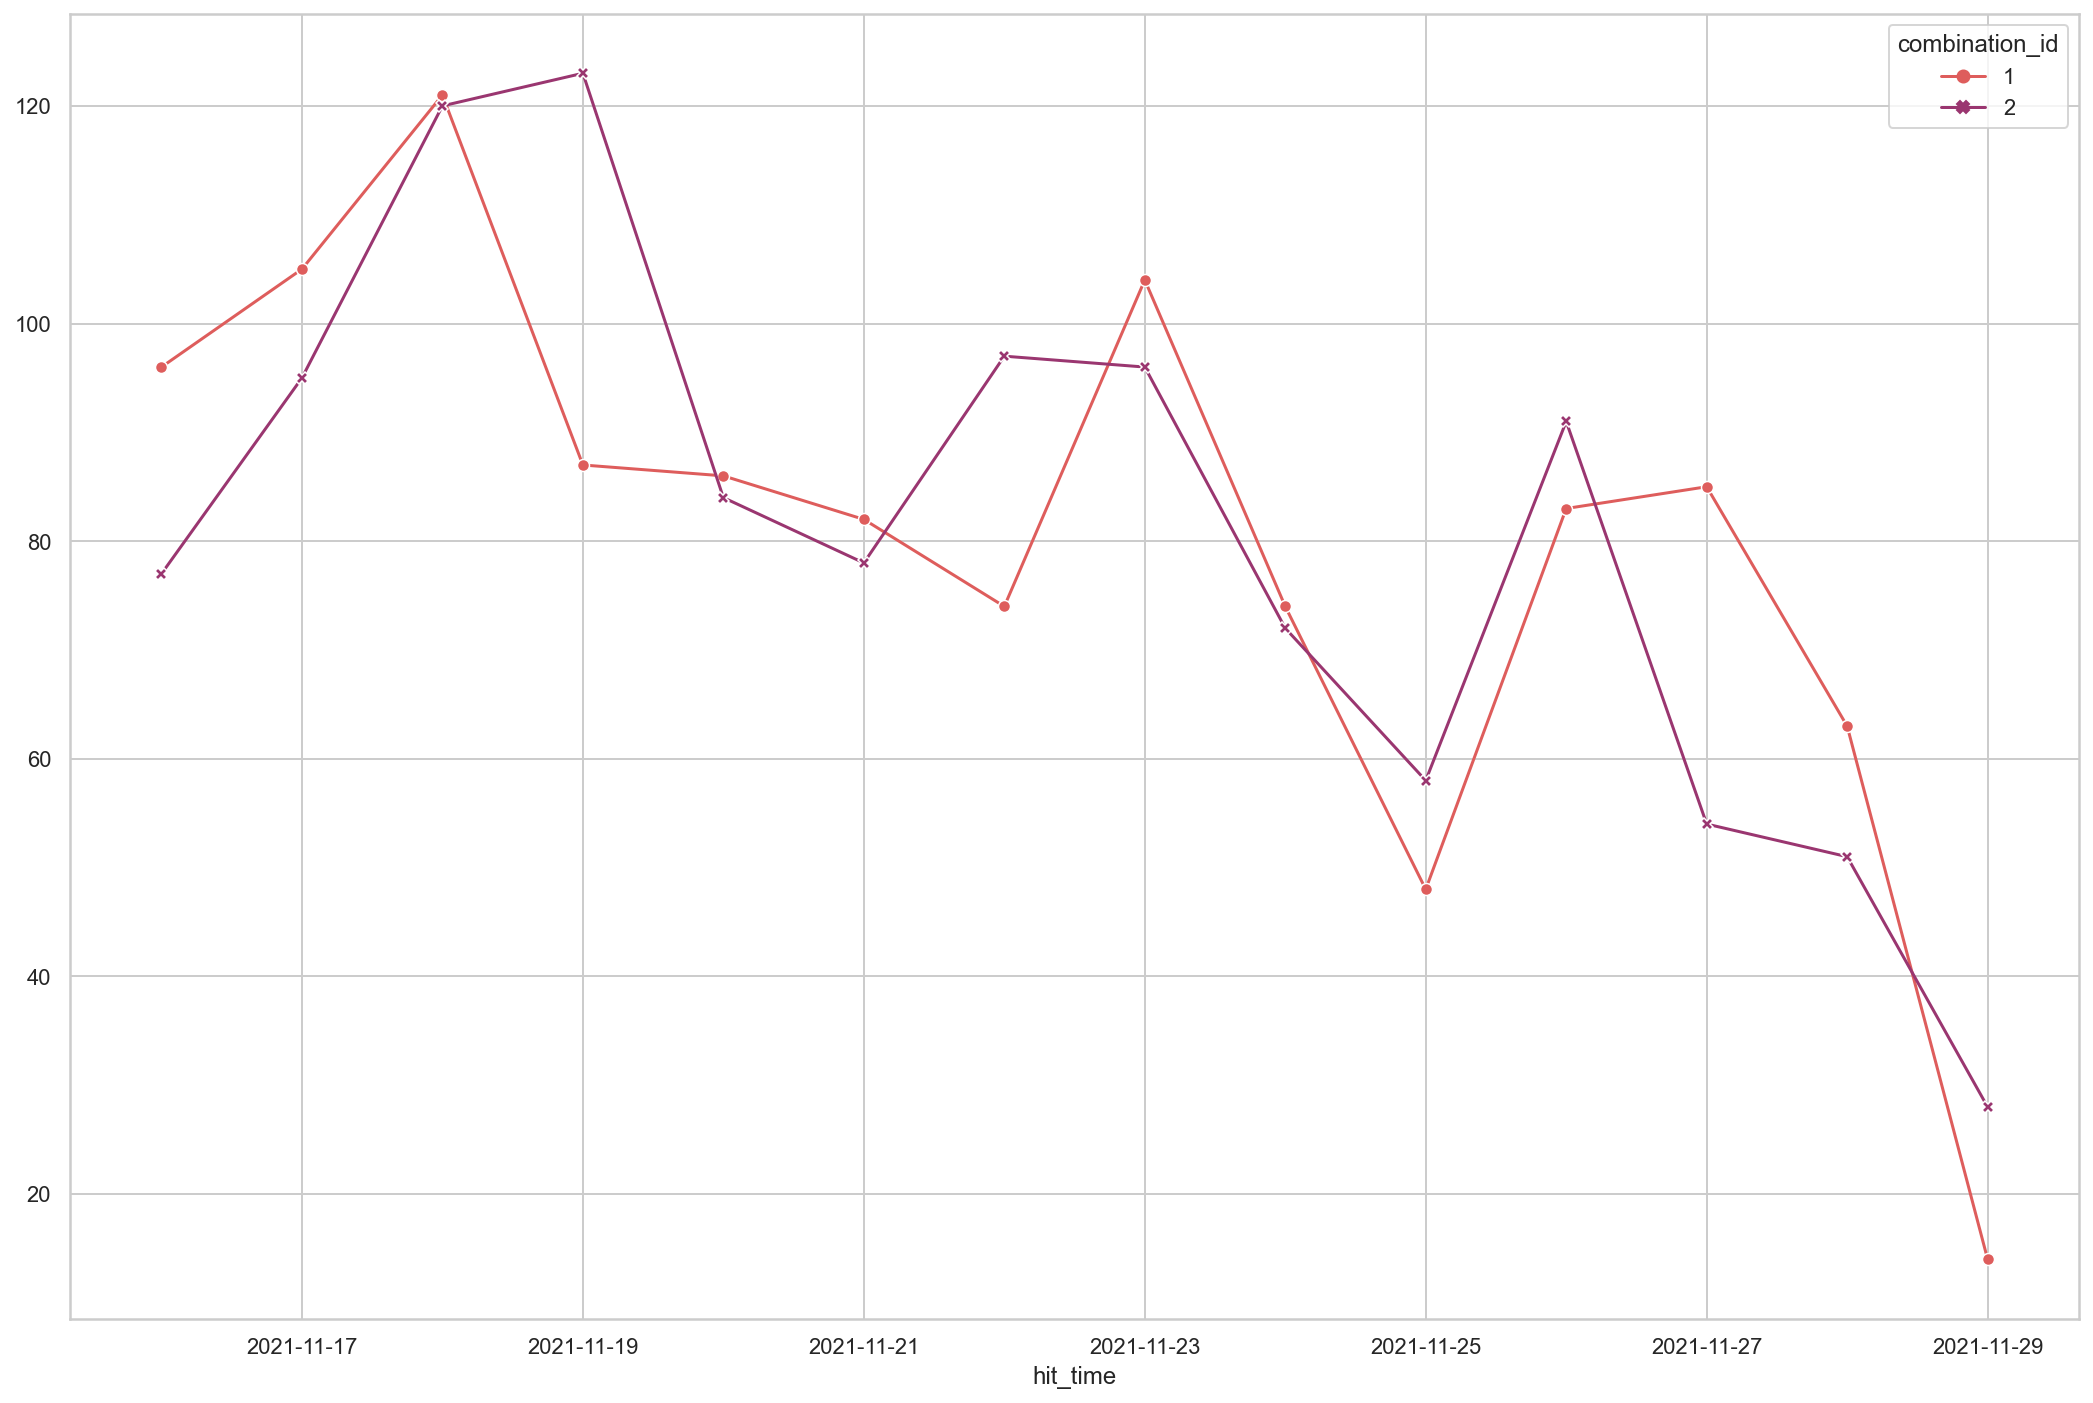

In [77]:
# RESAMPLE BY DAYS

gr = df.groupby([df['hit_time'].dt.date, df.combination_id]).size().unstack()
gr.index = gr.index.astype('datetime64[ns]')

sns.set_theme(style="whitegrid")
timeline = plt.subplots(figsize=(18, 12))
timeline = sns.lineplot(\
                       # height=12,\
                       # aspect=1.5,\
                       data=\
                       # df[df['combination_id']==1].groupby([df['hit_time'].dt.date]).size(),\
                       gr.resample('D').asfreq(),\
                       # kind="line",\
                       linewidth=1.5,\
                       markers=True,\
                       dashes=False,\
                       palette="flare", 
                      )
 


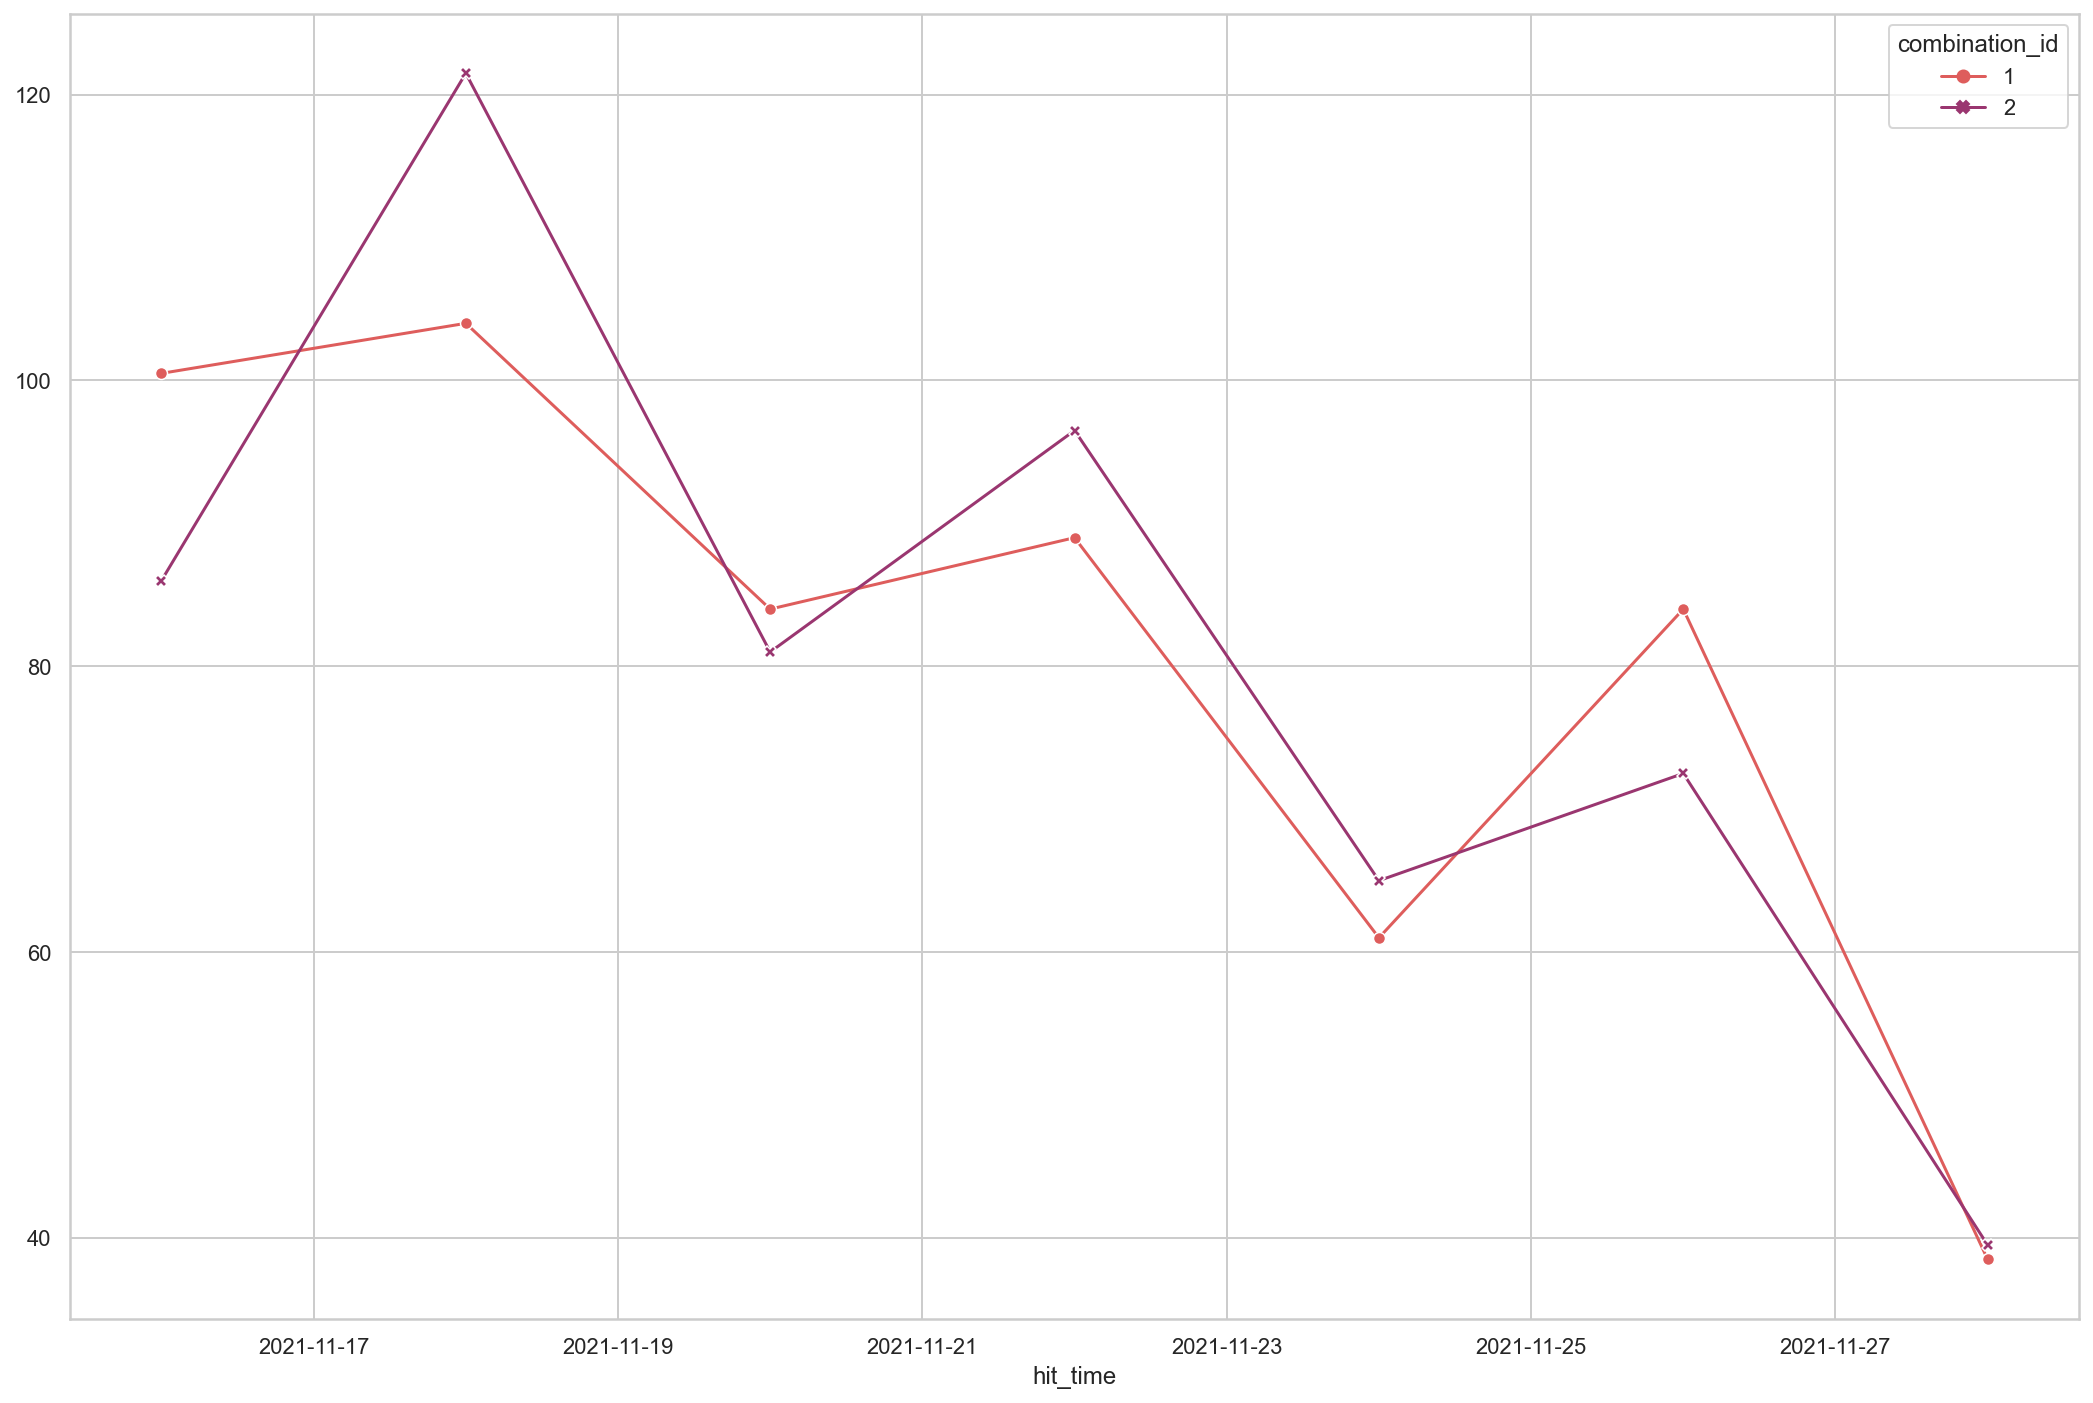

In [78]:
# RESAMPLE BY DAYS

gr = df.groupby([df['hit_time'].dt.date, df.combination_id]).size().unstack()
gr.index = gr.index.astype('datetime64[ns]')

sns.set_theme(style="whitegrid")
timeline = plt.subplots(figsize=(18, 12))
timeline = sns.lineplot(\
                       # height=12,\
                       # aspect=1.5,\
                       data=\
                       # df[df['combination_id']==1].groupby([df['hit_time'].dt.date]).size(),\
                       gr.resample('2D').mean(),\
                       # kind="line",\
                       linewidth=1.5,\
                       markers=True,\
                       dashes=False,\
                       palette="flare", 
                      )
 


variation groups order is [1, 2]


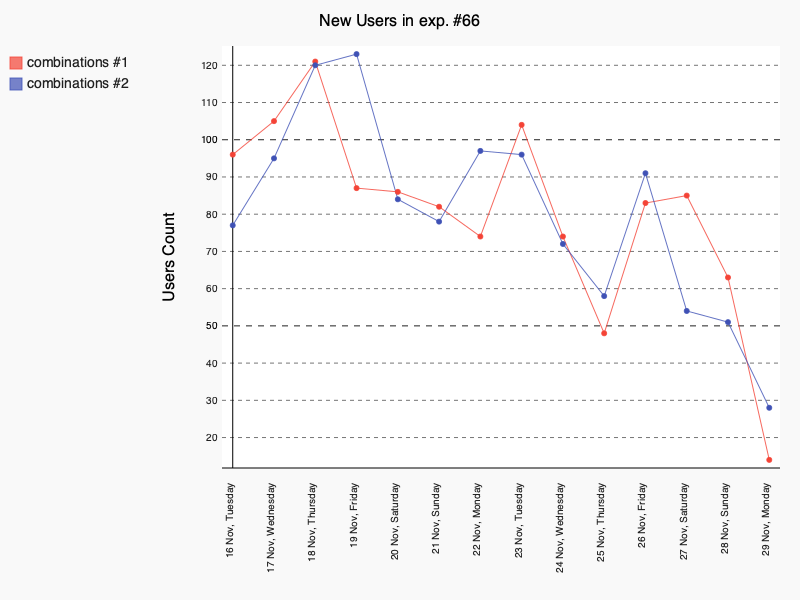

In [79]:
# Draw new user visits on DataTime Scale

factor = list(df['combination_id'].unique())
factor.sort()
date_chart = pygal.Line\
    (
#      fill=True,\
     x_label_rotation=270,\
     x_value_formatter=lambda dt: dt.strftime('%d %b, %A'),\
     y_title='Users Count')
date_chart.x_labels = df['hit_time'].dt.date.unique()

date_chart.title = 'New Users in exp. #{}'.format(exp)


for x in range(len(factor)):
    viz = date_chart.add('combinations #{}'.format(x+1), list(df[df['combination_id']==factor[x]].groupby([df['hit_time'].dt.date]).size()))
print('variation groups order is', factor)
date_chart

date_chart.render_to_file('/Users/rodiontereshkov/Downloads/new_visitors_exp{}.svg'.format(exp))

In [80]:
df.groupby([df['hit_time'].dt.date]).size().asfreq('2D').index

DatetimeIndex(['2021-11-16', '2021-11-18', '2021-11-20', '2021-11-22',
               '2021-11-24', '2021-11-26', '2021-11-28'],
              dtype='datetime64[ns]', name='hit_time', freq='2D')

variation groups order is [1, 2]


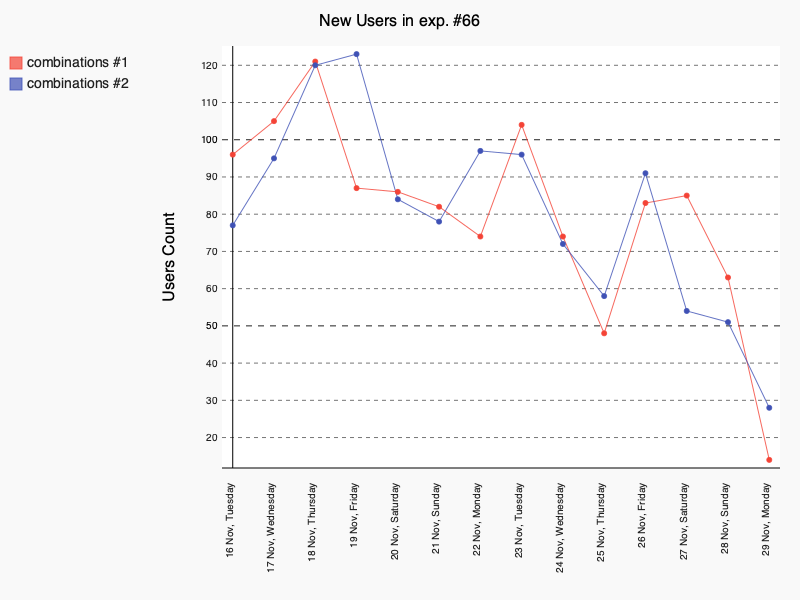

In [81]:
# Draw new user visits on DataTime Scale

factor = list(df['combination_id'].unique())
factor.sort()
date_chart = pygal.Line\
    (
#      fill=True,\
     x_label_rotation=270,\
     x_value_formatter=lambda dt: dt.strftime('%d %b, %A'),\
     y_title='Users Count')
date_chart.x_labels = df.groupby([df['hit_time'].dt.date]).size().asfreq('D').index

date_chart.title = 'New Users in exp. #{}'.format(exp)


for x in range(len(factor)):
    viz = date_chart.add('combinations #{}'.format(x+1), list(df[df['combination_id']==factor[x]].groupby([df['hit_time'].dt.date]).size()))
print('variation groups order is', factor)
date_chart

date_chart.render_to_file('/Users/rodiontereshkov/Downloads/new_visitors_exp{}.svg'.format(exp))

#### Draw Goals day by day

In [82]:
# # Draw new user visits on DataTime Scale
# goal_ids = meta['id'][:-3]

# for goal_id in goal_ids:
#     goal_name = meta[meta['id']==goal_id].name.values[0]
#     factor = list(df['combination_id'].unique())
#     factor.sort()
#     date_chart = pygal.Box\
#         (\
#          fill=True,\
#          x_label_rotation=270,\
#          x_value_formatter=lambda dt: dt.strftime('%d %b, %A'),\
#          value_formatter = lambda x:'{}%'.format(round(x*100, 4)),\
#          y_title='Conversion Percent')
# #     date_chart.x_labels = df['hit_time'].dt.date.unique()
#     date_chart.title = 'Goal - [#{} {}] in exp. #{}'.format(goal_id, goal_name, exp)


#     for x in range(len(factor)):
#         viz = date_chart.add('combinations #{}'.format(x+1),
#                              list(df[df['combination_id']==factor[x]]\
#                                   .groupby([df['hit_time'].dt.date])\
#                                   ['goal_{}_converted'.format(goal_id)].value_counts(normalize=True).unstack().iloc[:, -1].fillna(0).round(3)))
#     print('variation groups order is', factor)
#     date_chart
#     # date_chart.render_to_file('/Users/rodiontereshkov/Downloads/goal_{}_exp_{}_{}.svg'.format(goal_id, exp, today))

## CORRELATION ANALYSIS

In [47]:
meta

,category,id,name,type,created_timestamp,info
0,goal,1,engagement,engagement,2021-11-05 10:12:57,NaN
1,goal,203,ftd,custom-conversion,2021-11-04 13:17:44,NaN
2,goal,208,track_user_break,custom-conversion,2021-11-04 13:17:44,NaN
3,goal,209,track_selfexclusion,custom-conversion,2021-11-04 13:17:44,NaN
4,combination,1,Control,NaN,NaN,NaN
5,combination,2,Variation 1,NaN,NaN,NaN
6,campaign,66,[ABT-23] Limits,NaN,NaN,NaN


In [52]:
converted = list(df.columns[df.columns.str.endswith('_converted')])

In [53]:
unwanted = ['goal_206_converted','goal_207_converted',]

In [54]:
converted = [elem for elem in converted  if elem not in unwanted]

Text(0.5, 1.0, 'CORRELATION ANALYSIS for ALL GROUPS TOGETHER')

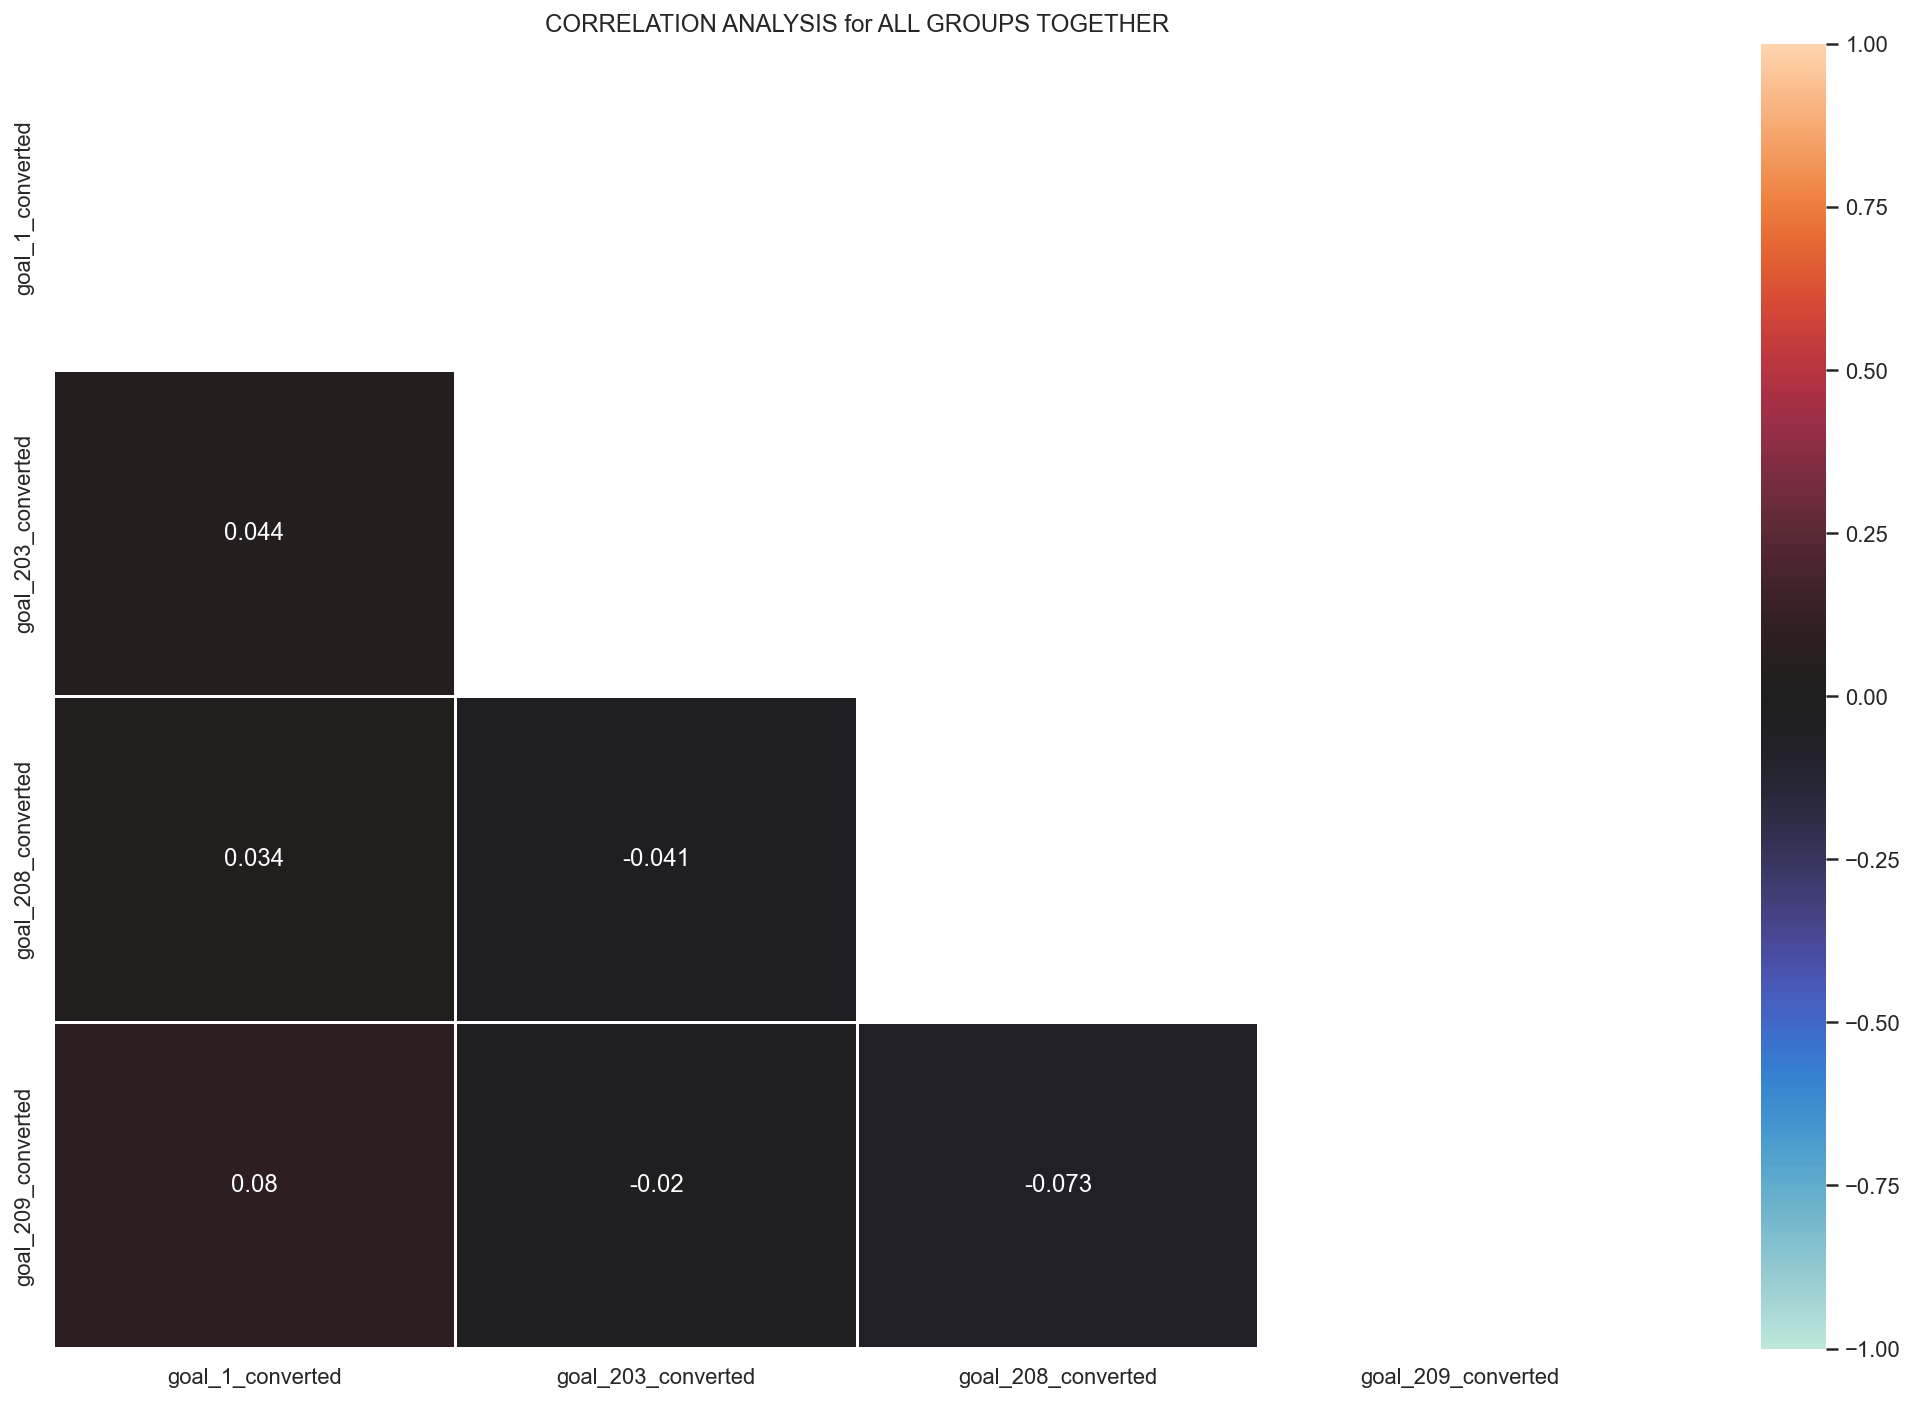

In [55]:
corr_new = df_goals[converted].corr()
mask = np.zeros_like(corr_new)
mask[np.triu_indices_from(mask)] = True

ax_nulls = plt.subplots(figsize=(18, 12))
ax_nulls = plt.subplot(111)
ax_nulls = sns.heatmap(corr_new,\
                      mask=mask,\
                      vmin=-1, vmax=1, annot=True, linewidths=1, center=0
                      )

ax_nulls.set_title('CORRELATION ANALYSIS for ALL GROUPS TOGETHER')

#### CORRELATION FOR EACH GROUP SEPARATELY

Text(0.5, 1.0, 'CORRELATION ANALYSIS for GROUP #1')

Text(0.5, 1.0, 'CORRELATION ANALYSIS for GROUP #2')

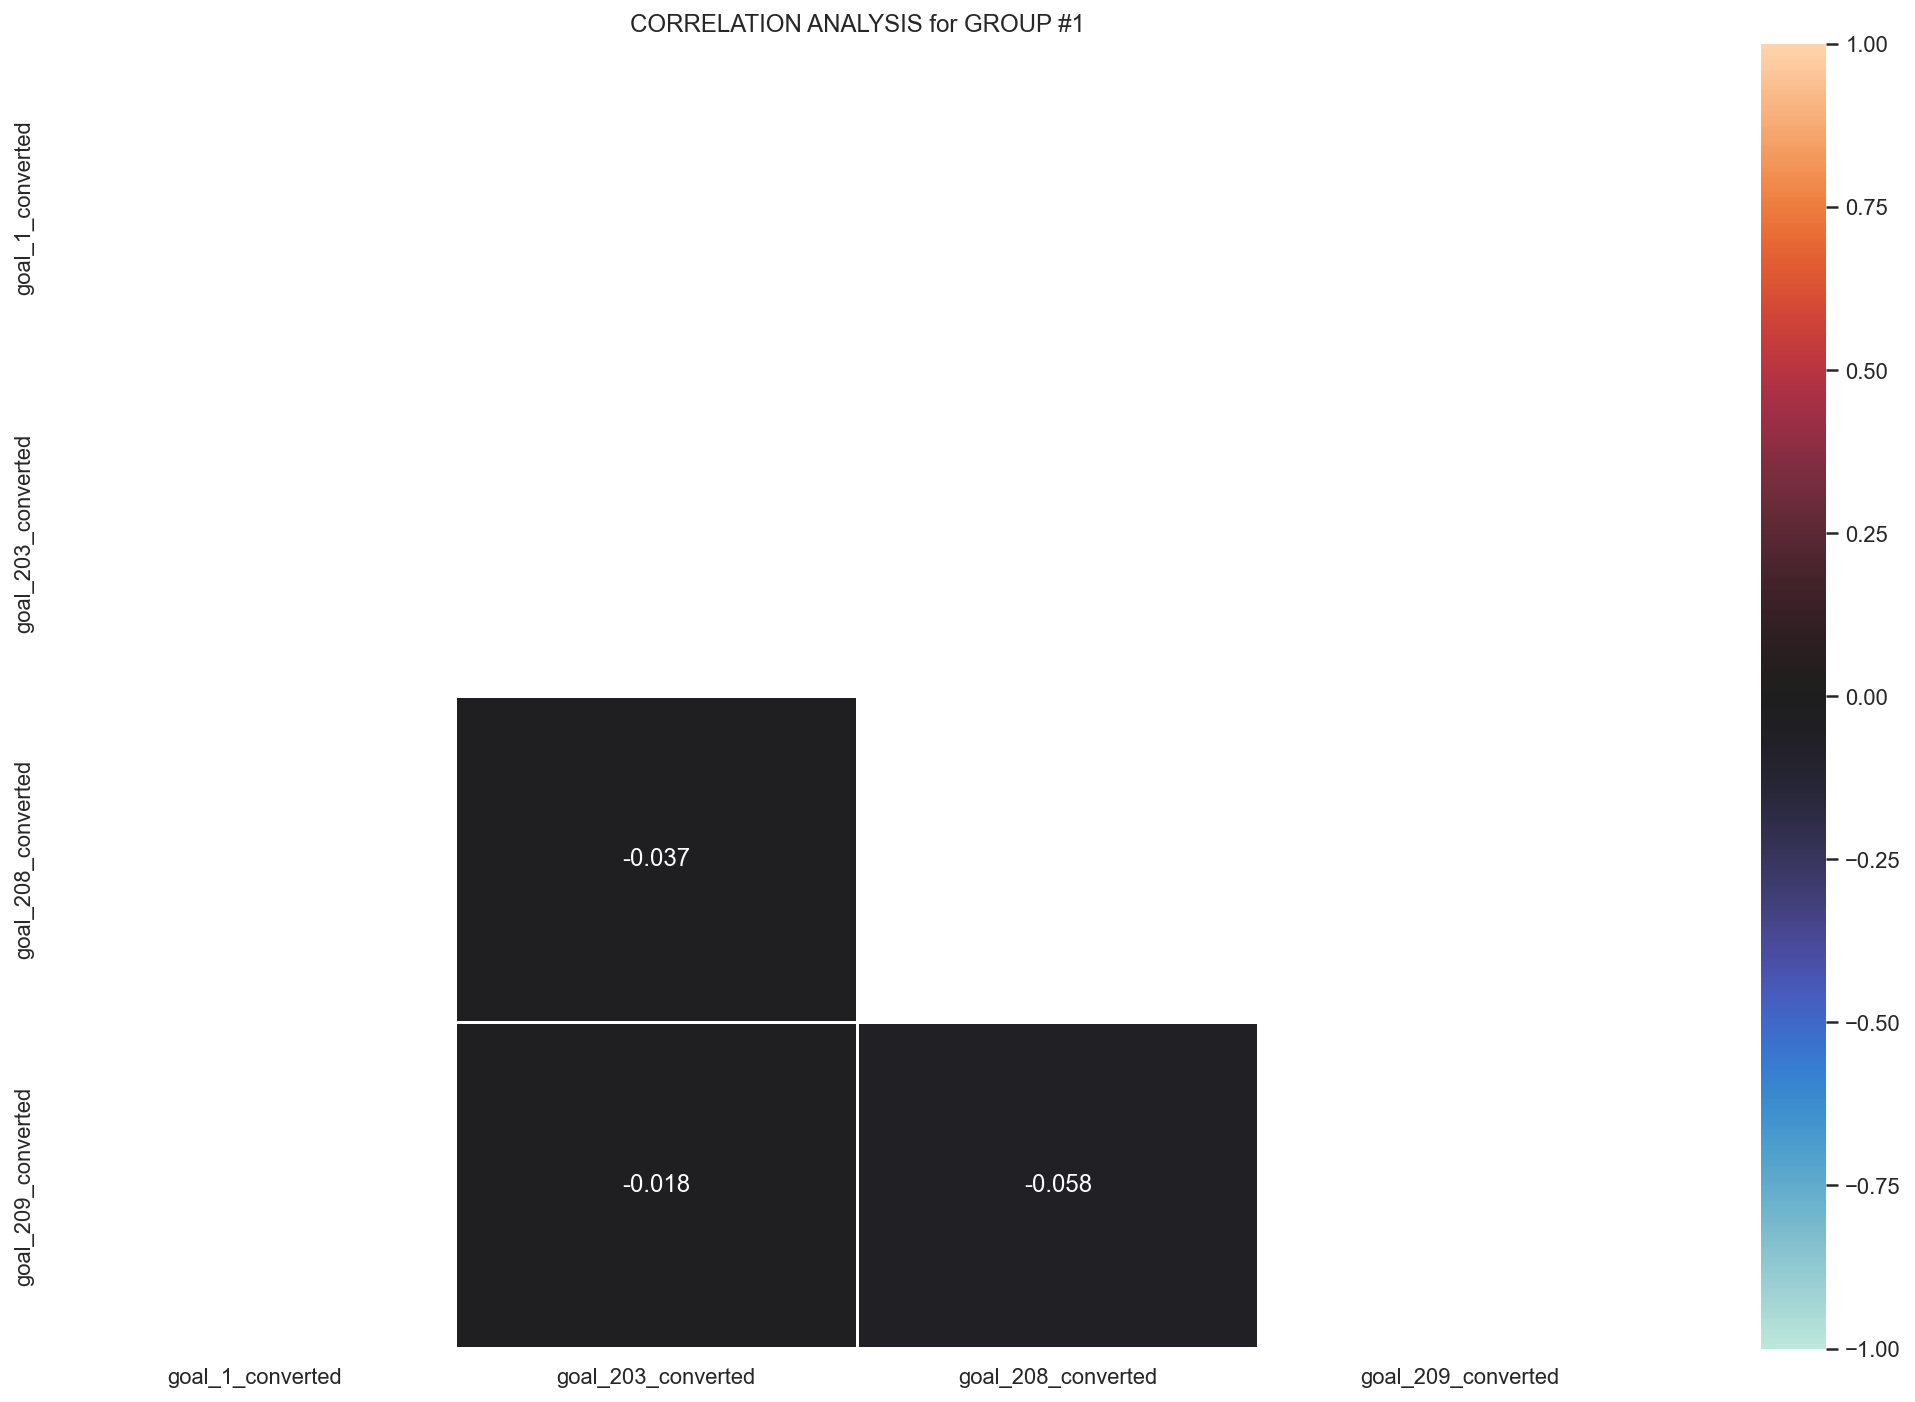

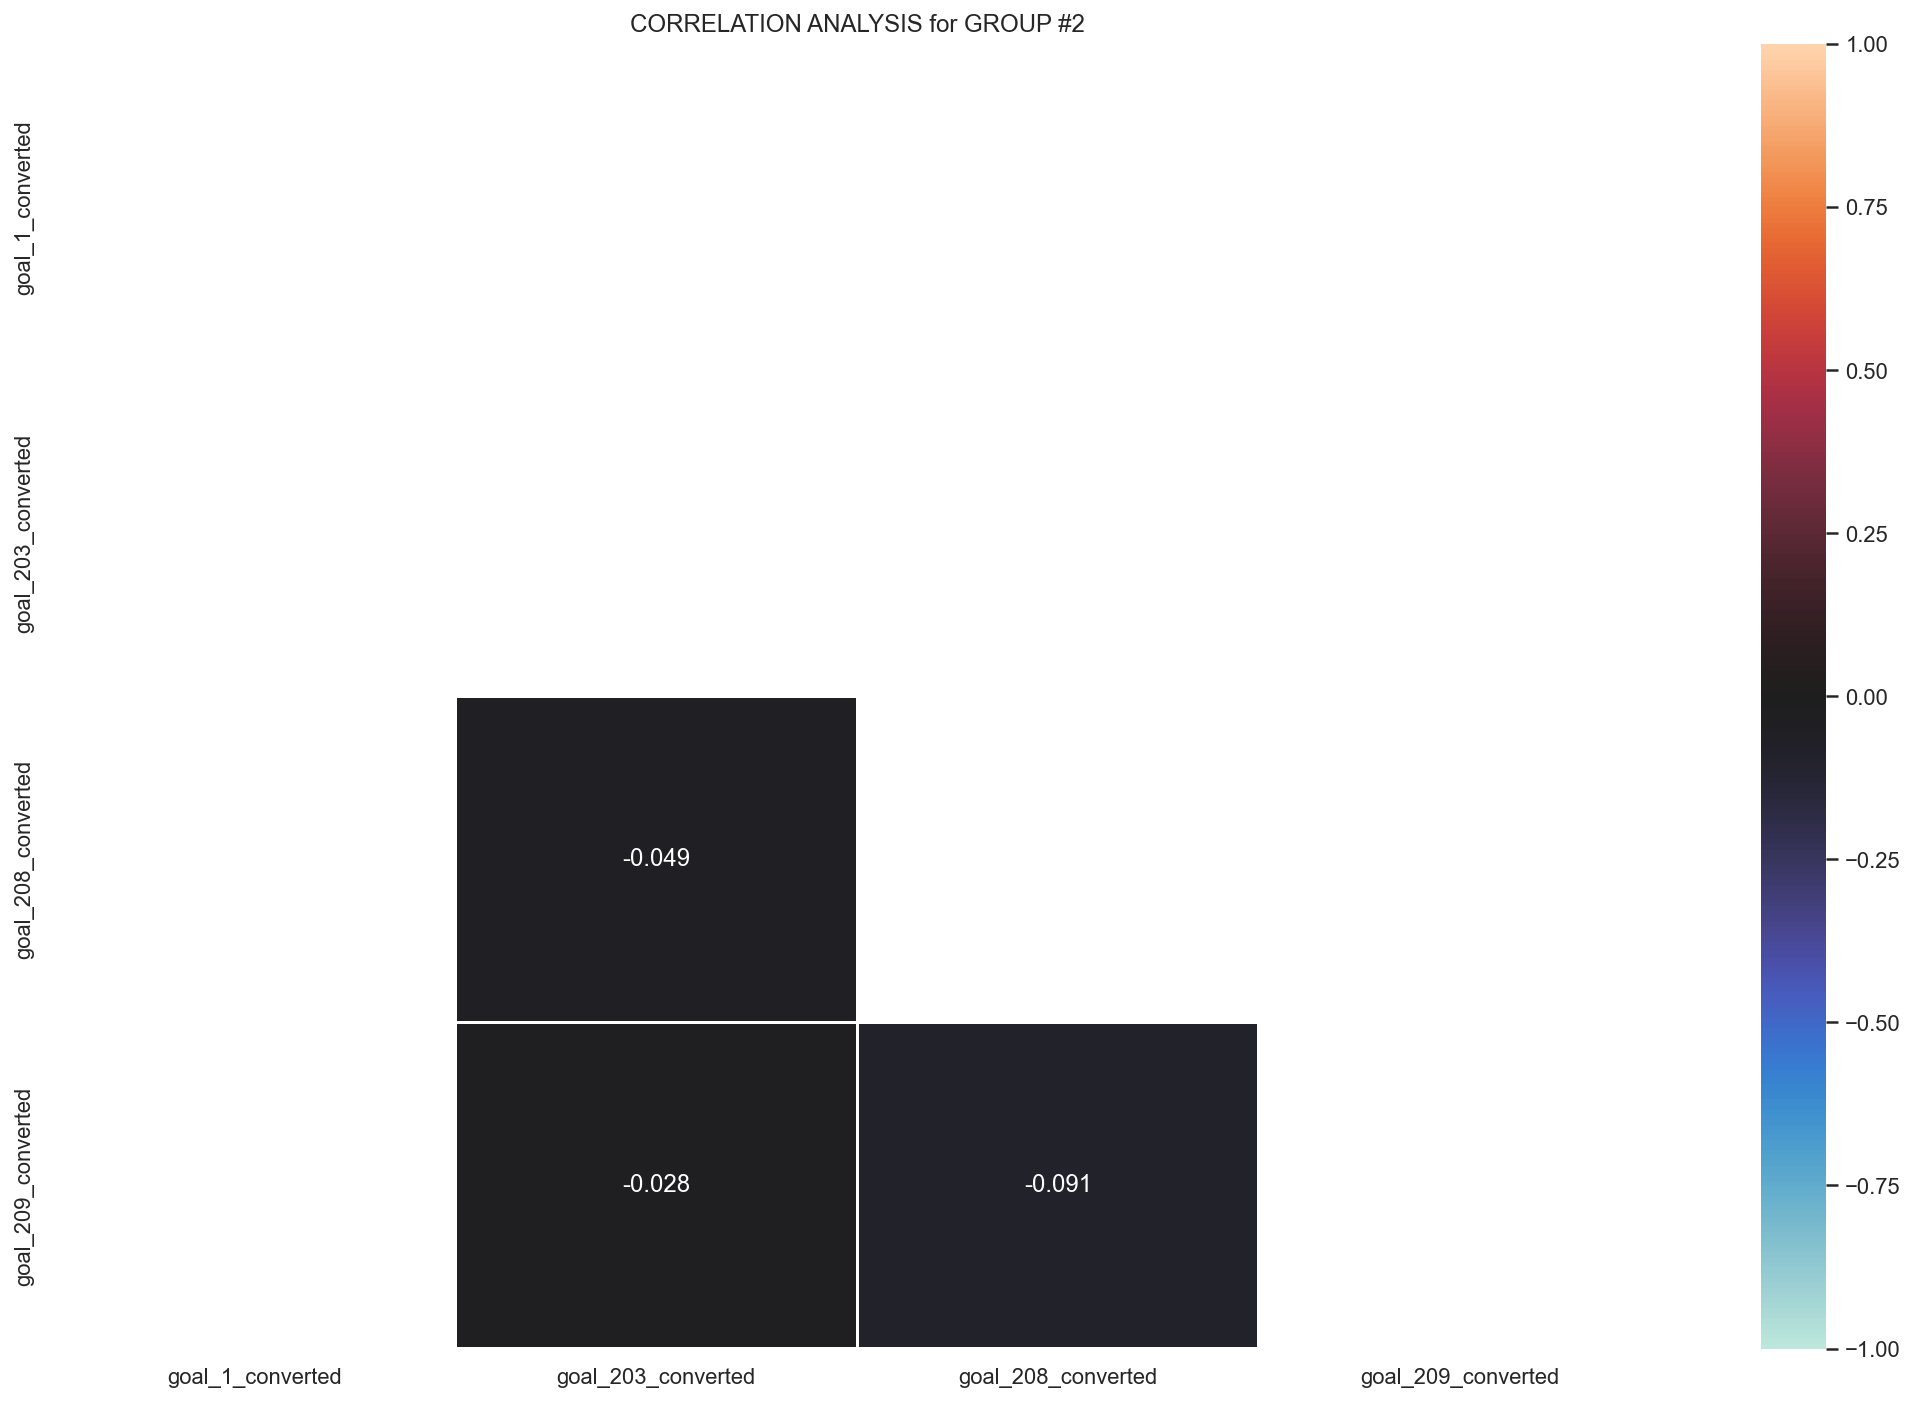

In [56]:
for x in range(1, df.combination_id.nunique()+1):
    corr_new = df[df['combination_id'] == x][converted].corr()
    mask = np.zeros_like(corr_new)
    mask[np.triu_indices_from(mask)] = True
    
    
    ax_nulls = plt.subplots(figsize=(18, 12))
    ax_nulls = sns.heatmap(corr_new,\
                          mask=mask,\
                          vmin=-1, vmax=1, annot=True, linewidths=1, center=0
                          )
    ax_nulls.set_title('CORRELATION ANALYSIS for GROUP #{}'.format(x))

In [57]:
df.groupby('combination_id').size()

combination_id
1    1077
2    1096
dtype: int64

In [58]:
df.shape

(2173, 45)

## P-VALUES

In [82]:
meta.iloc[:, :-1]

,category,id,name,type,created_timestamp
0,goal,1,engagement,engagement,2021-11-05 10:12:57
1,goal,203,ftd,custom-conversion,2021-11-04 13:17:44
2,goal,208,track_user_break,custom-conversion,2021-11-04 13:17:44
3,goal,209,track_selfexclusion,custom-conversion,2021-11-04 13:17:44
4,combination,1,Control,NaN,NaN
5,combination,2,Variation 1,NaN,NaN
6,campaign,66,[ABT-23] Limits,NaN,NaN


In [83]:
goal = 209
factor_p = df_factors.columns
newlist = []
newlist.append(abt.p_factor(goal='goal_{}_converted'.format(goal), df=df, variations=[1,2]))
for x in range(len(factor_p)):
    newlist.append(abt.p_factor(factor_p[x], goal='goal_{}_converted'.format(goal), df=df).rename(columns={factor_p[x]: 'factor'}))

result = pd.concat(newlist, ignore_index=True)

# RETURN GOAL INFO

meta.query('id == @goal')

# RETURN FULL RESULTS
result.style\
            .bar(subset=['p-value'], vmax=0.15, color=['#d65f5f'])\
            .bar(subset=['relative_uplift', 'absolute_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A','visitors_A', 'cr_A',\
                                  'n_of_conversions_B','visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


# RETURN SORTED RESULT
result.sort_values(by=['relative_uplift', 'absolute_uplift'], ascending=False).style\
            .bar(subset=['p-value'], vmax=0.15, color=['#d65f5f'])\
            .bar(subset=['relative_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A', 'visitors_A', 'cr_A',\
                                  'n_of_conversions_B', 'visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


# RETURN SORTED BY P-VALUE RESULT
result[result['p-value']<=0.2].sort_values(by=['p-value'], ascending=True).style\
            .bar(subset=['p-value'], vmax=0.15, color=['#d65f5f'])\
            .bar(subset=['relative_uplift', 'absolute_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A','visitors_A', 'cr_A',\
                                  'n_of_conversions_B','visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


,category,id,name,type,created_timestamp,info
3,goal,209,track_selfexclusion,custom-conversion,2021-11-04 13:17:44,NaN


,factor,visitors_A,visitors_B,n_of_conversions_A,n_of_conversions_B,cr_A,cr_B,relative_uplift,p-value,absolute_uplift
0,all_population,1122,1124,183,216,16.31,19.22,17.82,0.04,2.91
1,mobile,922,923,149,176,16.16,19.07,17.99,0.05,2.91
2,desktop,196,195,33,38,16.84,19.49,15.74,0.25,2.65
3,new_user,426,445,57,72,13.38,16.18,20.92,0.12,2.80
4,returning_user,696,679,126,144,18.10,21.21,17.15,0.07,3.10
5,android,707,687,99,124,14.00,18.05,28.90,0.02,4.05
6,windows,188,185,31,37,16.49,20.00,21.29,0.19,3.51
7,ios,219,242,51,54,23.29,22.31,-4.18,0.40,-0.97
8,chrome,211,208,29,40,13.74,19.23,39.92,0.07,5.49
9,chrome_mobile,523,504,83,102,15.87,20.24,27.52,0.03,4.37


,factor,visitors_A,visitors_B,n_of_conversions_A,n_of_conversions_B,cr_A,cr_B,relative_uplift,p-value,absolute_uplift
8,chrome,211,208,29,40,13.74,19.23,39.92,0.07,5.49
5,android,707,687,99,124,14.00,18.05,28.90,0.02,4.05
9,chrome_mobile,523,504,83,102,15.87,20.24,27.52,0.03,4.37
12,ro_ro,384,396,67,84,17.45,21.21,21.57,0.09,3.76
6,windows,188,185,31,37,16.49,20.00,21.29,0.19,3.51
3,new_user,426,445,57,72,13.38,16.18,20.92,0.12,2.80
11,romania,1100,1097,181,215,16.45,19.60,19.11,0.03,3.14
1,mobile,922,923,149,176,16.16,19.07,17.99,0.05,2.91
0,all_population,1122,1124,183,216,16.31,19.22,17.82,0.04,2.91
13,False,1122,1124,183,216,16.31,19.22,17.82,0.04,2.91


,factor,visitors_A,visitors_B,n_of_conversions_A,n_of_conversions_B,cr_A,cr_B,relative_uplift,p-value,absolute_uplift
5,android,707,687,99,124,14.00,18.05,28.90,0.02,4.05
11,romania,1100,1097,181,215,16.45,19.60,19.11,0.03,3.14
9,chrome_mobile,523,504,83,102,15.87,20.24,27.52,0.03,4.37
0,all_population,1122,1124,183,216,16.31,19.22,17.82,0.04,2.91
13,False,1122,1124,183,216,16.31,19.22,17.82,0.04,2.91
1,mobile,922,923,149,176,16.16,19.07,17.99,0.05,2.91
8,chrome,211,208,29,40,13.74,19.23,39.92,0.07,5.49
4,returning_user,696,679,126,144,18.10,21.21,17.15,0.07,3.10
12,ro_ro,384,396,67,84,17.45,21.21,21.57,0.09,3.76
3,new_user,426,445,57,72,13.38,16.18,20.92,0.12,2.80


In [85]:
goal = 208
factor_p = df_factors.columns
newlist = []
newlist.append(abt.p_factor(goal='goal_{}_converted'.format(goal), df=df, variations=[1,2]))
for x in range(len(factor_p)):
    newlist.append(abt.p_factor(factor_p[x], goal='goal_{}_converted'.format(goal), df=df).rename(columns={factor_p[x]: 'factor'}))

result = pd.concat(newlist, ignore_index=True)

# RETURN GOAL INFO

meta.query('id == @goal')

# RETURN FULL RESULTS
result.style\
            .bar(subset=['p-value'], vmax=0.1, color=['#d65f5f'])\
            .bar(subset=['relative_uplift', 'absolute_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A','visitors_A', 'cr_A',\
                                  'n_of_conversions_B','visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


# RETURN SORTED RESULT
result.sort_values(by=['relative_uplift', 'absolute_uplift'], ascending=False).style\
            .bar(subset=['p-value'], vmax=0.1, color=['#d65f5f'])\
            .bar(subset=['relative_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A', 'visitors_A', 'cr_A',\
                                  'n_of_conversions_B', 'visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


# RETURN SORTED BY P-VALUE RESULT
result[result['p-value']<=0.2].sort_values(by=['p-value'], ascending=True).style\
            .bar(subset=['p-value'], vmax=0.1, color=['#d65f5f'])\
            .bar(subset=['relative_uplift', 'absolute_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A','visitors_A', 'cr_A',\
                                  'n_of_conversions_B','visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


,category,id,name,type,created_timestamp,info
2,goal,208,track_user_break,custom-conversion,2021-11-04 13:17:44,NaN


,factor,visitors_A,visitors_B,n_of_conversions_A,n_of_conversions_B,cr_A,cr_B,relative_uplift,p-value,absolute_uplift
0,all_population,1122,1124,46,37,4.10,3.29,-19.71,0.16,-0.81
1,mobile,922,923,41,32,4.45,3.47,-22.04,0.14,-0.98
2,returning_user,696,679,37,29,5.32,4.27,-19.66,0.18,-1.05
3,android,707,687,30,21,4.24,3.06,-27.96,0.12,-1.19
4,romania,1100,1097,46,37,4.18,3.37,-19.35,0.16,-0.81
5,False,1122,1124,46,37,4.10,3.29,-19.71,0.15,-0.81


,factor,visitors_A,visitors_B,n_of_conversions_A,n_of_conversions_B,cr_A,cr_B,relative_uplift,p-value,absolute_uplift
4,romania,1100,1097,46,37,4.18,3.37,-19.35,0.16,-0.81
2,returning_user,696,679,37,29,5.32,4.27,-19.66,0.18,-1.05
0,all_population,1122,1124,46,37,4.10,3.29,-19.71,0.16,-0.81
5,False,1122,1124,46,37,4.10,3.29,-19.71,0.15,-0.81
1,mobile,922,923,41,32,4.45,3.47,-22.04,0.14,-0.98
3,android,707,687,30,21,4.24,3.06,-27.96,0.12,-1.19


,factor,visitors_A,visitors_B,n_of_conversions_A,n_of_conversions_B,cr_A,cr_B,relative_uplift,p-value,absolute_uplift
3,android,707,687,30,21,4.24,3.06,-27.96,0.12,-1.19
1,mobile,922,923,41,32,4.45,3.47,-22.04,0.14,-0.98
5,False,1122,1124,46,37,4.10,3.29,-19.71,0.15,-0.81
0,all_population,1122,1124,46,37,4.10,3.29,-19.71,0.16,-0.81
4,romania,1100,1097,46,37,4.18,3.37,-19.35,0.16,-0.81
2,returning_user,696,679,37,29,5.32,4.27,-19.66,0.18,-1.05


In [64]:
goal = 203
factor_p = df_factors.columns
newlist = []
newlist.append(abt.p_factor(goal='goal_{}_converted'.format(goal), df=df, variations=[1,2]))
for x in range(len(factor_p)):
    newlist.append(abt.p_factor(factor_p[x], goal='goal_{}_converted'.format(goal), df=df).rename(columns={factor_p[x]: 'factor'}))

result = pd.concat(newlist, ignore_index=True)

# RETURN GOAL INFO

meta.query('id == @goal')

# RETURN FULL RESULTS
result.style\
            .bar(subset=['p-value'], vmax=0.1, color=['#d65f5f'])\
            .bar(subset=['relative_uplift', 'absolute_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A','visitors_A', 'cr_A',\
                                  'n_of_conversions_B','visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


# RETURN SORTED RESULT
result.sort_values(by=['relative_uplift', 'absolute_uplift'], ascending=False).style\
            .bar(subset=['p-value'], vmax=0.1, color=['#d65f5f'])\
            .bar(subset=['relative_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A', 'visitors_A', 'cr_A',\
                                  'n_of_conversions_B', 'visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


# RETURN SORTED BY P-VALUE RESULT
result[result['p-value']<=0.2].sort_values(by=['p-value'], ascending=True).style\
            .bar(subset=['p-value'], vmax=0.1, color=['#d65f5f'])\
            .bar(subset=['relative_uplift', 'absolute_uplift'], vmin=0.0, color=['#5fba7d'])\
            .background_gradient(\
                          subset=['n_of_conversions_A','visitors_A', 'cr_A',\
                                  'n_of_conversions_B','visitors_B', 'cr_B'], cmap='Blues', low=0, high=0.3)\
            .set_precision(2)


,category,id,name,type,created_timestamp,info
1,goal,203,ftd,custom-conversion,2021-11-04 13:17:44,NaN


,factor,visitors_A,visitors_B,n_of_conversions_A,n_of_conversions_B,cr_A,cr_B,relative_uplift,p-value,absolute_uplift
0,all_population,1077,1096,70,71,6.50,6.48,-0.33,0.49,-0.02
1,mobile,885,899,62,56,7.01,6.23,-11.08,0.26,-0.78
2,new_user,401,430,37,41,9.23,9.53,3.34,0.44,0.31
3,returning_user,676,666,33,30,4.88,4.50,-7.73,0.37,-0.38
4,android,678,670,45,47,6.64,7.01,5.69,0.39,0.38
5,chrome_mobile,504,489,36,38,7.14,7.77,8.79,0.35,0.63
6,romania,1057,1071,70,71,6.62,6.63,0.10,0.50,0.01
7,ro_ro,371,387,30,23,8.09,5.94,-26.50,0.12,-2.14
8,False,1077,1096,70,71,6.50,6.48,-0.33,0.49,-0.02


,factor,visitors_A,visitors_B,n_of_conversions_A,n_of_conversions_B,cr_A,cr_B,relative_uplift,p-value,absolute_uplift
5,chrome_mobile,504,489,36,38,7.14,7.77,8.79,0.35,0.63
4,android,678,670,45,47,6.64,7.01,5.69,0.39,0.38
2,new_user,401,430,37,41,9.23,9.53,3.34,0.44,0.31
6,romania,1057,1071,70,71,6.62,6.63,0.10,0.50,0.01
0,all_population,1077,1096,70,71,6.50,6.48,-0.33,0.49,-0.02
8,False,1077,1096,70,71,6.50,6.48,-0.33,0.49,-0.02
3,returning_user,676,666,33,30,4.88,4.50,-7.73,0.37,-0.38
1,mobile,885,899,62,56,7.01,6.23,-11.08,0.26,-0.78
7,ro_ro,371,387,30,23,8.09,5.94,-26.50,0.12,-2.14


,factor,visitors_A,visitors_B,n_of_conversions_A,n_of_conversions_B,cr_A,cr_B,relative_uplift,p-value,absolute_uplift
7,ro_ro,371,387,30,23,8.09,5.94,-26.50,0.12,-2.14


### TIMESTAMPS

In [84]:
df.groupby('combination_id')['209_goal_secs'].describe()

,count,mean,std,min,25%,50%,75%,max
combination_id,,,,,,,,
1,183.0,39058.956284,116893.035434,-1.0,35.50,60.0,6273.50,776730.0
2,216.0,50262.541667,149051.159024,7.0,38.75,65.0,4970.75,989196.0


In [66]:
goal_number = 209
goal='{}_goal_secs'.format(goal_number)

for x in range(len(df_factors.columns)):
    print('FACTOR - {}'.format(df_factors.columns[x]).upper())
    abt.tta(df_factors.columns[x], goal=goal, df=df)

FACTOR - DEVICE_TYPE


,device_type,count_A,count_B,50%_A,50%_B,75%_A,75%_B
0,mobile,146,167,60.0,65.0,6417.25,4447.5


FACTOR - RETURNING_VISITOR


,returning_visitor,count_A,count_B,50%_A,50%_B,75%_A,75%_B
0,new_user,56,70,70.0,60.5,4622.0,2395.75
1,returning_user,123,137,55.0,63.0,5876.5,2309.00


FACTOR - OS


,os,count_A,count_B,50%_A,50%_B,75%_A,75%_B
0,android,97,117,60.0,80.0,4154.0,8524.00
1,ios,50,52,62.5,54.5,9155.5,215.75


FACTOR - BROWSER


,browser,count_A,count_B,50%_A,50%_B,75%_A,75%_B
0,chrome_mobile,81,98,62.0,78.5,6561.0,7384.75


FACTOR - COUNTRY


,country,count_A,count_B,50%_A,50%_B,75%_A,75%_B
0,romania,177,206,60.0,63.5,5192.0,2423.0


FACTOR - USER_LANGUAGE


,user_language,count_A,count_B,50%_A,50%_B,75%_A,75%_B
0,ro_ro,65,80,74.0,58.0,12255.0,3441.25


FACTOR - LAND


,land,count_A,count_B,50%_A,50%_B,75%_A,75%_B
0,False,179,207,60.0,63.0,5060.0,2385.0


In [67]:
df.groupby('combination_id')['208_goal_secs'].describe()

,count,mean,std,min,25%,50%,75%,max
combination_id,,,,,,,,
1,46.0,55199.217391,115414.628274,34.0,68.5,122.0,42733.75,483307.0
2,36.0,90391.361111,187020.202415,19.0,56.5,98.0,111122.50,708145.0


In [56]:
goal_number = 203
goal='{}_goal_secs'.format(goal_number)

for x in range(len(df_factors.columns)):
    print('FACTOR - {}'.format(df_factors.columns[x]).upper())
    abt.tta(df_factors.columns[x], goal=goal, df=df)

FACTOR - DEVICE_TYPE


,device_type,count_A,count_B,50%_A,50%_B,75%_A,75%_B
0,mobile,138,151,203.5,193.0,524.0,674.0


FACTOR - RETURNING_VISITOR


,returning_visitor,count_A,count_B,50%_A,50%_B,75%_A,75%_B
0,new_user,150,163,214.0,205.0,524.0,866.5


FACTOR - OS


,os,count_A,count_B,50%_A,50%_B,75%_A,75%_B
0,android,98,113,203.5,191.0,468.25,636.0


FACTOR - BROWSER


,browser,count_A,count_B,50%_A,50%_B,75%_A,75%_B
0,chrome_mobile,74,84,206.5,177.0,509.25,643.5


FACTOR - COUNTRY


,country,count_A,count_B,50%_A,50%_B,75%_A,75%_B
0,romania,155,173,211.0,218.0,582.0,690.0


FACTOR - USER_LANGUAGE


,user_language,count_A,count_B,50%_A,50%_B,75%_A,75%_B
0,ro_ro,93,109,191.0,230.0,352.0,703.0


FACTOR - LAND


,land,count_A,count_B,50%_A,50%_B,75%_A,75%_B
0,False,186,205,181.0,205.0,509.25,703.0


## ARPU & ARPPU

In [68]:
# FIND REVENUE GOALS
revenue = df.columns[df.columns.str.startswith('goal_') & df.columns.str.endswith('_revenue')]
revenue = revenue[0]
revenue

IndexError: index 0 is out of bounds for axis 0 with size 0

In [60]:
revenue_converted = revenue.split('revenue')[0] + 'converted'
revenue_converted

'goal_3_converted'

In [61]:
df[revenue].mean()

59.19999999999995

In [62]:
arppu = df.groupby(['combination_id'])[revenue].mean()
arppu

combination_id
1    46.995833
2    70.204913
Name: goal_3_revenue, dtype: float64

In [63]:
df.groupby(['combination_id'])[revenue].count()

combination_id
1    468
2    519
Name: goal_3_revenue, dtype: int64

In [64]:
df.groupby(['combination_id'])[revenue_converted].sum()

combination_id
1    468
2    519
Name: goal_3_converted, dtype: int64

In [65]:
df.groupby(['combination_id'])[revenue_converted].count()

combination_id
1    1366
2    1399
Name: goal_3_converted, dtype: int64

In [66]:
df[[revenue, revenue_converted]]

,goal_3_revenue,goal_3_converted
5,23.46,1
6,82.13,1
7,232.45,1
9,NaN,0
10,NaN,0
...,...,...
3845,11.59,1
3849,4.23,1
3850,NaN,0
3851,NaN,0


In [67]:
df.groupby('combination_id')[revenue].sum()

combination_id
1    21994.05
2    36436.35
Name: goal_3_revenue, dtype: float64

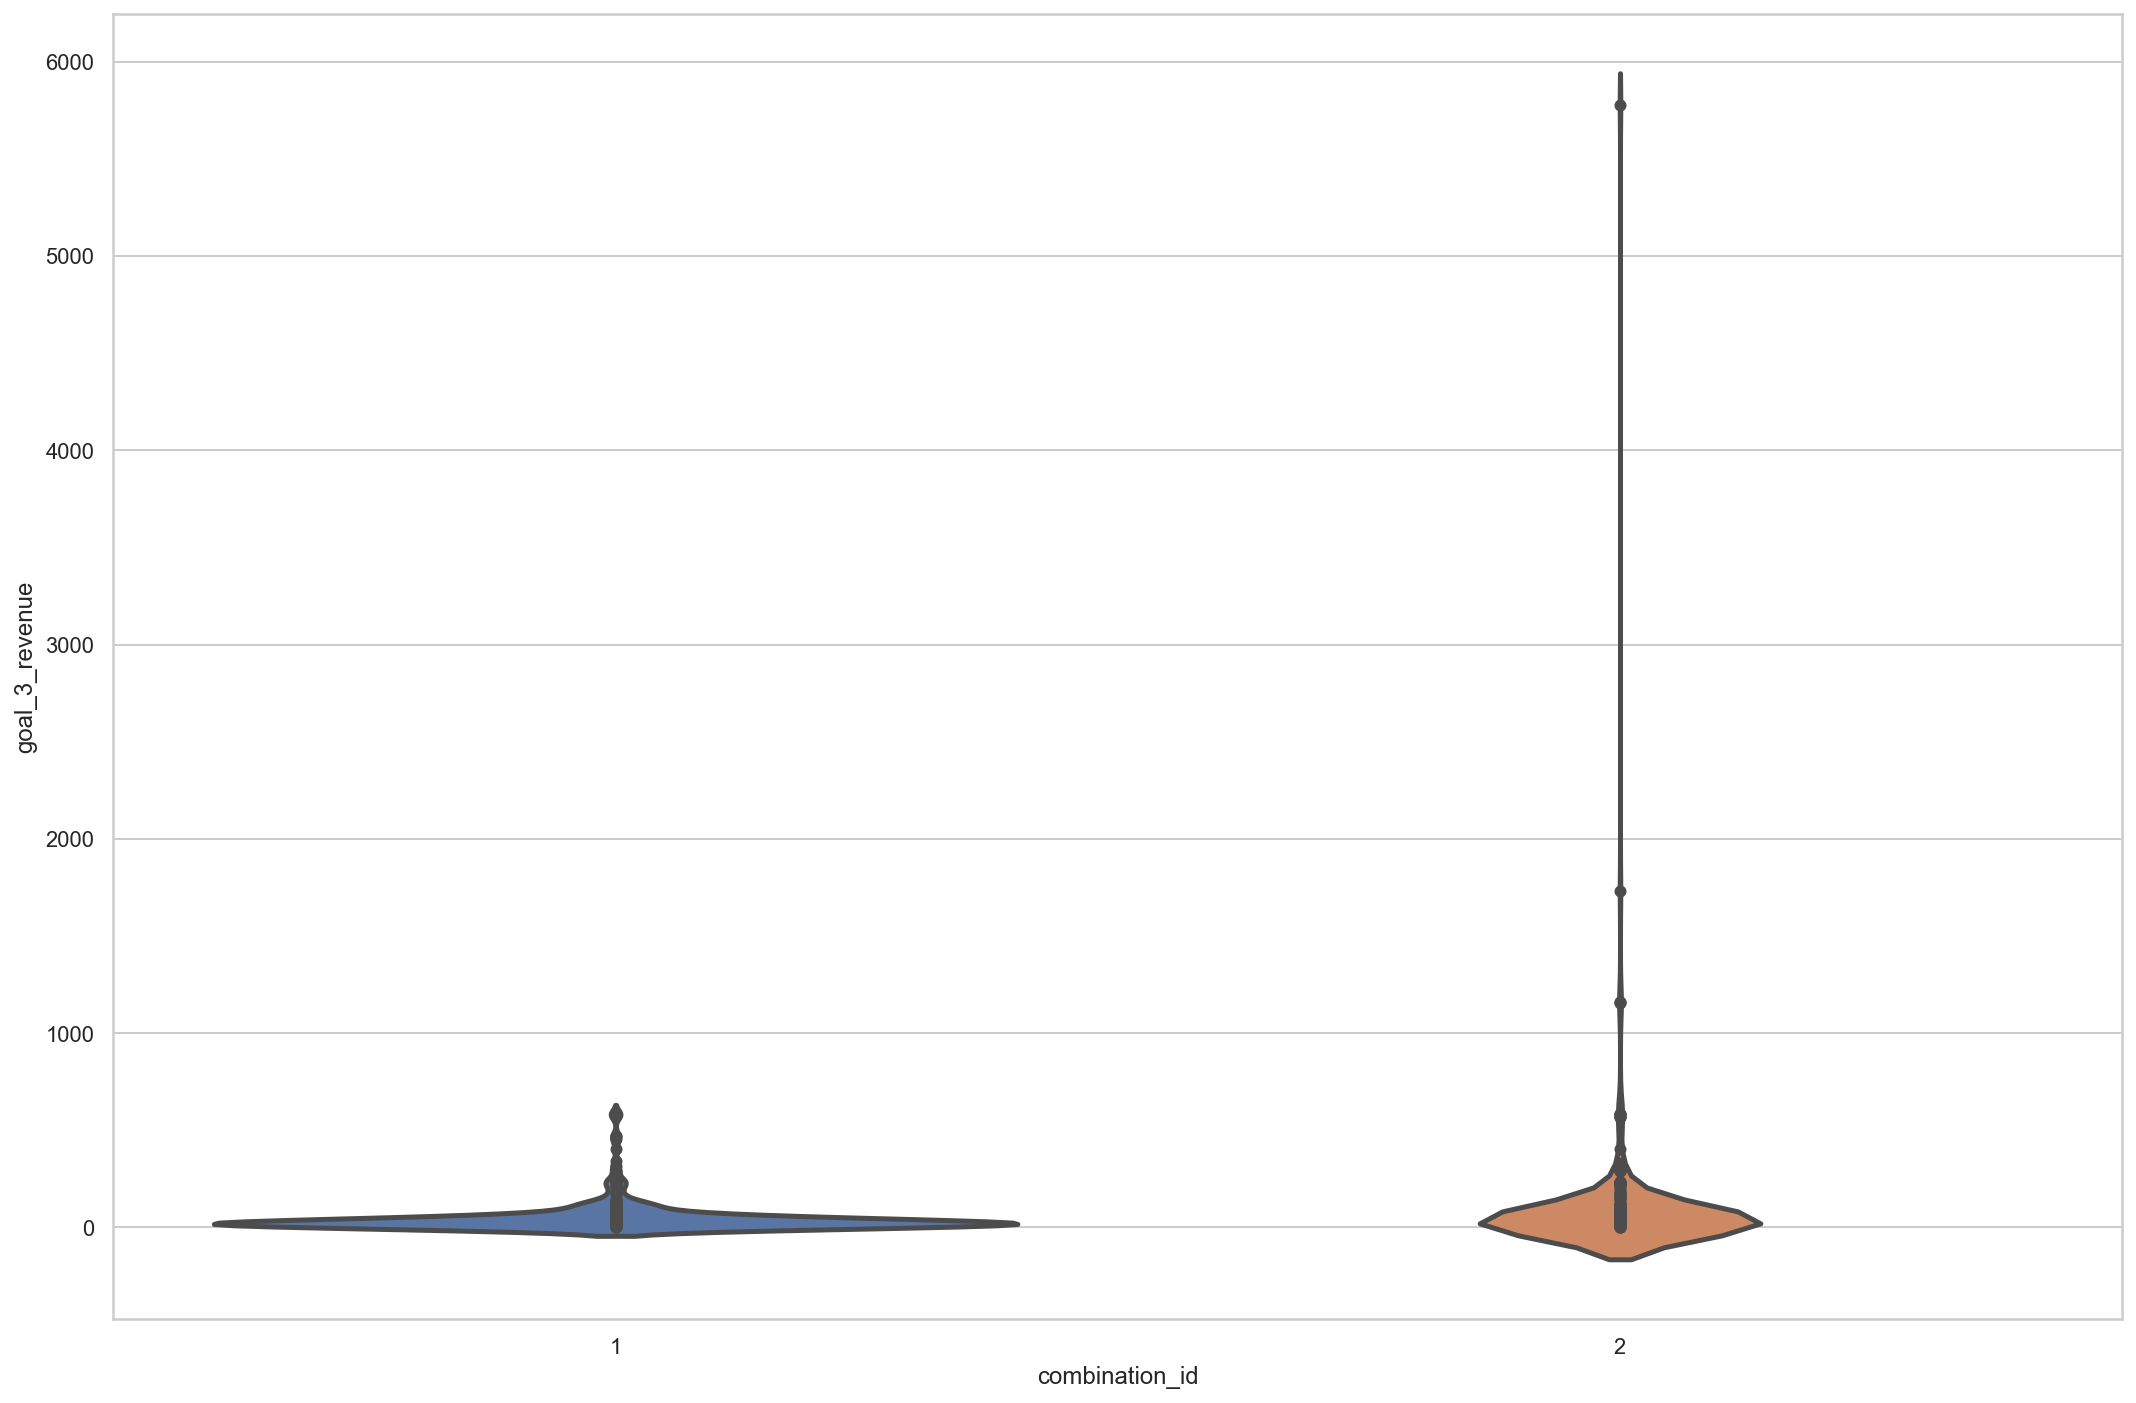

In [68]:
ax_nulls = plt.subplots(figsize=(18, 12))
ax_nulls = sns.violinplot(x='combination_id',\
                       y=df[revenue],\
                       data=df,\
#                        hue='os',\
                       linewidth=2.5,\
                       inner='point',\
                      )
# plt.axis([-1, 2, -75, 200])

## RUNNING EXPERIMENTS

In [69]:
import requests

url = "https://app.vwo.com/api/v2/accounts/{}/campaigns?status=RUNNING".format(FC)

headers = {
    "Accept": "application/json",
    "token": "90d8bd096a224e7f6b72a2000bab409d7a8063aba48d7a4424e9220de96483bd"
}

response = requests.request("GET", url, headers=headers)
json = response.json()

In [72]:
exps = pd.json_normalize(json['_data'])

In [81]:
exps.query('status=="RUNNING" & type=="ab"').iloc[:, :10]

,id,name,type,platform,status,createdOn,isDeleted,labels,primaryUrl,urls
0,66,[ABT-23] Limits,ab,website,RUNNING,1636031864,False,[],https://frankcasino.ro/en,"[{'type': 'pattern', 'value': 'https://frankcasino.ro/*'}, {'type': 'url', 'value': 'https://fra..."


## CONNECT HEAPPO

In [278]:
import psycopg2
connect = psycopg2.connect(host="10.208.72.65", port = 6432, database="heappo", user="rodion_ter_ro_user", password="dv33msfu84ndjsh3bz7")
cur = connect.cursor()

In [279]:
cur.execute("""
SELECT * FROM gambling.vwo_experiments WHERE (campaign_id = 123)""")

In [280]:
colnames = [desc[0] for desc in cur.description]

In [281]:
query_results = cur.fetchall()
sql_stage = pd.DataFrame(query_results, columns=colnames)

In [282]:
sql_stage

,vwo_uuid,user_id,campaign_id,campaign_name,campaign_type,variations,goals,version,rest,project_id,created_at,updated_at
0,D0BECCC30FA802E026FDCED4EDF509153,0,123,[SC] ABT-34 New Cashier,ab,[{'2': 'New Widget'}],{},1636444015.934939,{'id': 1950},sc1,2021-11-03 08:41:37.467,2021-11-03 14:21:05.664
1,D0BECCC30FA802E026FDCED4EDF509153,14420,123,[SC] ABT-34 New Cashier,ab,[{'2': 'New Widget'}],{},1636018473.052552,{'id': 1964},sc1,2021-11-04 09:33:31.449,2021-11-04 09:33:31.449
2,D0BECCC30FA802E026FDCED4EDF509153,14472,123,[SC] ABT-34 New Cashier,ab,[{'2': 'New Widget'}],{},1635949337.783359,{'id': 1959},sc1,2021-11-03 14:21:10.249,2021-11-03 14:21:10.249
3,D19C7825402079C8D905421DF425F740B,0,123,[SC] ABT-34 New Cashier,ab,[{'2': 'New Widget'}],{},1636130208.277771,{'id': 1987},sc1,2021-11-05 10:30:35.516,2021-11-05 10:30:35.516
4,D5C4D85FF9A896A88F503C56C36E9B228,0,123,[SC] ABT-34 New Cashier,ab,[],{},1635932675.318724,{'id': 1955},sc1,2021-11-03 09:36:14.980,2021-11-03 09:36:14.980
5,D79FDD104A6C9C32C4E3AEDEBE9ADBDF3,0,123,[SC] ABT-34 New Cashier,ab,[{'1': 'Control'}],{'2': 'engagement'},1636369223.364676,{'id': 2000},sc1,2021-11-08 10:49:02.277,2021-11-08 10:49:02.277
6,D954E5D9AFCEE919FAFC96B55A897161C,0,123,[SC] ABT-34 New Cashier,ab,[{'1': 'Control'}],{'2': 'engagement'},1636036804.228605,{'id': 1979},sc1,2021-11-04 14:38:57.986,2021-11-04 14:38:57.986
7,DBA8B9B13C28EC935B000A82D8DAC0CE3,0,123,[SC] ABT-34 New Cashier,ab,[{'2': 'New Widget'}],{},1636124360.25595,{'id': 1989},sc1,2021-11-05 14:59:15.348,2021-11-05 14:59:15.348
8,DED2F795D5F370974113EE2B2086AA6EF,0,123,[SC] ABT-34 New Cashier,ab,[{'2': 'New Widget'}],{'2': 'engagement'},1636452362.4681,{'id': 1982},sc1,2021-11-05 08:21:08.857,2021-11-05 08:21:08.857
9,DED2F795D5F370974113EE2B2086AA6EF,0,123,[SC] ABT-34 New Cashier,ab,[],{},1636460466.972378,{'id': 232},sc3,2021-11-09 11:57:06.214,2021-11-09 11:57:06.214


In [285]:
cur.close()
connect.close()

## DRAFT

In [118]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, CategoricalEncoder
ordinal_encoder = OrdinalEncoder()
hot_encoder = OneHotEncoder()


ImportError: cannot import name 'CategoricalEncoder' from 'sklearn.preprocessing' (/Users/rodiontereshkov/.local/lib/python3.8/site-packages/sklearn/preprocessing/__init__.py)

In [112]:
df_encoded = ordinal_encoder.fit_transform(df[['os', 'combination_name']])
df_hot_encoded = hot_encoder.fit_transform(df[['os', 'combination_name']])

In [113]:
df_encoded

array([[1., 0.],
       [1., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 0.],
       [4., 1.]])

In [114]:
ordinal_encoder.categories_

[array(['android', 'ios', 'linux', 'mac_os_x', 'windows'], dtype=object),
 array(['control', 'variation_1'], dtype=object)]

In [116]:
df_hot_encoded.toarray()

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.]])

In [117]:
hot_encoder.categories_

[array(['android', 'ios', 'linux', 'mac_os_x', 'windows'], dtype=object),
 array(['control', 'variation_1'], dtype=object)]

In [119]:
list(df)

['screen_resolution',
 'query_parameters',
 'ip',
 'browser',
 'browser_version',
 'device_type',
 'device',
 'os',
 'os_version',
 'user_agent',
 'traffic_source',
 'combination_id',
 'combination_name',
 'converted',
 'goal_id',
 'conversion_time',
 'returning_visitor',
 'hit_time',
 'user_language',
 'url',
 'referring_url',
 'city',
 'region',
 'country',
 'custom_dimension',
 'goal_1_converted',
 'goal_1_converted_time',
 'goal_203_converted',
 'goal_203_converted_time',
 'goal_208_converted',
 'goal_208_converted_time',
 'goal_209_converted',
 'goal_209_converted_time',
 'day',
 'jurisdiction',
 'uuid',
 'hashed_user_id',
 'has_duplicates',
 'domain',
 'land',
 'land_number',
 '1_goal_secs',
 '203_goal_secs',
 '208_goal_secs',
 '209_goal_secs']